In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## ✭✭ 샘플 데이터 및 내용 보안 주의 당부

## 1. 배경/목적
- 앱내 특정화면에 업소를 노출하기 위한 랭킹 스코어 산출 & 지표 모니터링 및 고도화
- 최종적으로, 특정 서비스/기능의 유저 만족도를 측정하고 개선하기 위한 근거 마련

## 2. 분석 Frame
- **테이블 추출 및 전처리**
    - 테이블 추출 및 조인
    - 전처리
- **데이터 탐색 및 변수 이해**
    - 분포 확인 및 시각화
    - 선형 변환 및 신규 변수 생성
- **스코어 산출**
    - 가중치 부여 산정/협의
    - 스코어 계산
- **사전/사후 검증 및 지표 트래킹**
    - 사전 설문을 통한 검증
    - 실제 배포후 지표 모니터링
- **로직 설계 고도화**
    - 개인화 추천 (CF, Contents-based)
    - 쿼터 지정
    - A/B Testing
    
![img](rank_framework.png)    
   

## 3. 데이터 추출 및 생성

- **목적: 업소별(유니크) feature 구축**
    - 업소별 기본정보(Base)
    - 업소별 주문정보 
    - 업소별 리뷰수 및 평균별점
    - 업소별 즐겨찾기 수
    - 업소별 노출 및 클릭건수(클릭율)
    - 업소별 객단가, 주문취소율, 재주문율
    - 리뷰 텍스트 마이닝?    

### 3.1 업소별 기본 정보: Base Table

```python
# 업소별, 지역 및 등록일자 테이블 추출 쿼리 => base tb
df = spark.sql("""
                 select 
                    A.shop_no,
                    A.shop_nm,
                    B.rgn2_nm,
                    A.reg_dt
                from sbsvc.shop A
                left join
                (
                select 
                    det_cd as rgn2_cd, 
                    cd_nm as rgn2_nm
                from sbsvc.comm_cd 
                where main_cd = 'B0007' and det_cd <> '$'
                ) B
                on A.rgn2_cd = B.rgn2_cd
                where A.rgn2_cd <> '99999'
                """)\
            .filter("ct_cd == '30' or ct_cd == '31'")\
            .filter("use_yn == 'Y' and block_yn == 'N'")
```            

In [6]:
# 업소 기본정보
shop = pd.read_csv("tb1_base_shopinfo.csv")

In [7]:
shop.head()

,shop_no,rgn2_nm,reg_dt
0,36235,관악구,2010-02-28
1,39647,성남시 분당구,2010-05-20
2,459193,관악구,2013-01-30
3,522695,강서구,2014-07-22
4,563770,송파구,2015-05-13


In [8]:
shop.tail()

,shop_no,rgn2_nm,reg_dt
3794,755746,강남구,2018-03-30
3795,755775,강서구,2018-03-31
3796,755777,양천구,2018-03-31
3797,755779,강서구,2018-03-31
3798,89915,부평구,2011-06-20


In [9]:
shop.shop_no.is_unique

True

In [10]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 3 columns):
shop_no    3799 non-null int64
rgn2_nm    3799 non-null object
reg_dt     3799 non-null object
dtypes: int64(1), object(2)
memory usage: 89.1+ KB


In [11]:
shop['reg_dt'] = pd.to_datetime(shop['reg_dt'])

In [12]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 3 columns):
shop_no    3799 non-null int64
rgn2_nm    3799 non-null object
reg_dt     3799 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 89.1+ KB


In [13]:
shop.head() # base table

,shop_no,rgn2_nm,reg_dt
0,36235,관악구,2010-02-28
1,39647,성남시 분당구,2010-05-20
2,459193,관악구,2013-01-30
3,522695,강서구,2014-07-22
4,563770,송파구,2015-05-13


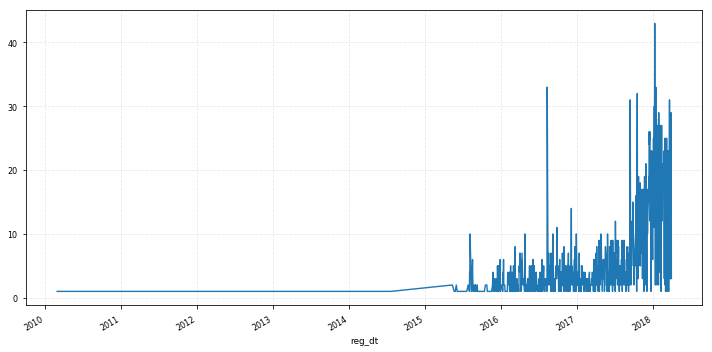

In [14]:
shop.groupby("reg_dt").size().plot(figsize=(10,5))

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### 3.2 업소별 주문 정보 

```python
# 업소별 주문 기록 추출 쿼리
ord = spark.sql("""
                select
                    ord_no,
                    shop_no,
                    dvc_id,
                    ord_price,
                    ord_dt
                from sbtasty.tasty_ord 
                where ord_prog_cd = '2' 
                    and ord_dt >= '2018-03-22'
                    and ord_dt < '2018-03-29'
                """)
```

In [15]:
# 주문 정보
shop_ord_tb = pd.read_csv("tb2_ord.csv")

shop_ord_tb.head()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
0,TBJSVF018963,627879,OPUD9B95F362-69E0-495A-A920-6DCC0AED5989,9000,3,2018-03-28
1,TBIUZX013748,611777,OPUD2b10ee558d42a2a6,15900,2,2018-03-28
2,TBODPL001502,705469,OPUD77DD1E51-DF1F-4E1C-8A0E-CA2FCDDD9C70,55300,2,2018-03-28
3,TBKSLN013277,645203,OPUD6b4322f7a96bb571,12500,2,2018-03-28
4,TBLBZB012571,651639,OPUDFD52FBEA-10CA-4022-B283-AFB70BA0204C,23000,2,2018-03-28


In [16]:
shop_ord_tb.tail()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
81389,TBMDYD014988,670543,OPUDeefa511a121fe497,15000,2,2018-03-24
81390,TBNWXL005812,700945,OPUDAD072DE5-8D09-48D4-BA37-48E806A9EDAB,32000,2,2018-03-24
81391,TBODPL001463,705469,OPUD005EE077-7F11-4D8A-B9A9-87E822FF13CC,20800,2,2018-03-24
81392,TBOQXJ001497,714463,OPUD735701AE-89DC-4E7F-84CF-F25E5202FD05,22000,2,2018-03-24
81393,TBQCCN000860,739609,OPUD1EC781CD-6056-493E-AA5D-FF26193F0143,16000,2,2018-03-24


In [17]:
shop_ord_tb['shop_no'].is_unique

False

In [18]:
shop_ord_tb['ord_no'].is_unique

True

In [19]:
shop_ord_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81394 entries, 0 to 81393
Data columns (total 6 columns):
ord_no         81394 non-null object
shop_no        81394 non-null int64
dvc_id         81392 non-null object
ord_price      81394 non-null int64
ord_prog_cd    81394 non-null int64
ord_dt         81394 non-null object
dtypes: int64(3), object(3)
memory usage: 3.7+ MB


In [20]:
shop_ord_tb['shop_no'] = shop_ord_tb['shop_no'].astype(str)
shop_ord_tb['ord_dt'] = pd.to_datetime(shop_ord_tb['ord_dt'])

In [21]:
shop_ord_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81394 entries, 0 to 81393
Data columns (total 6 columns):
ord_no         81394 non-null object
shop_no        81394 non-null object
dvc_id         81392 non-null object
ord_price      81394 non-null int64
ord_prog_cd    81394 non-null int64
ord_dt         81394 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.7+ MB


In [22]:
shop_ord_tb.groupby("ord_dt").size()

ord_dt
2018-03-22    10118
2018-03-23    11157
2018-03-24    15435
2018-03-25    16212
2018-03-26     9513
2018-03-27     9575
2018-03-28     9384
dtype: int64

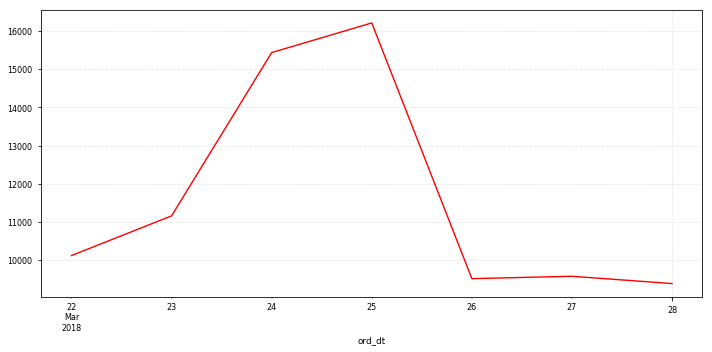

In [23]:
shop_ord_tb.groupby("ord_dt").size().plot(color='red', figsize=(10,5))

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [24]:
## code info.
# 2: ord finally complete, 3: ord canceled

shop_ord_tb['ord_prog_cd'].value_counts()

2    78752
3     2642
Name: ord_prog_cd, dtype: int64

In [25]:
# 업소당 주문수

shop_ord = shop_ord_tb.query("ord_prog_cd == '2'").groupby("shop_no")['ord_no'].count().reset_index()
shop_ord.columns = ['shop_no', 'ord_cnt']

shop_ord.head(10)

,shop_no,ord_cnt
0,36235,15
1,459193,61
2,522695,62
3,563770,75
4,563771,95
5,565051,26
6,565209,24
7,565434,6
8,566297,10
9,566306,17


In [26]:
shop_ord.describe().round(2)

,ord_cnt
count,3304.00
mean,23.84
std,31.01
min,1.00
25%,5.00
50%,14.00
75%,30.00
max,439.00


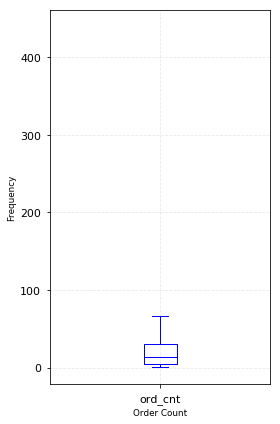

In [27]:
shop_ord.plot(kind='box', figsize=(4,6), fontsize=11, color='blue');

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.xlabel("Order Count")
plt.ylabel("Frequency")
plt.tight_layout()

### 3.3 업소별 리뷰 갯수 및 별점 정보 

```python
# 리뷰 및 별점 추출 쿼리
shop_rvw_star = spark.sql("""
                    select 
                        shop_no,
                        count(distinct shop_review_seq) rvw_cnt,
                        round(avg(star_pnt),3) mean_star_pnt
                    from sbsvc.shop_review
                    where reg_dt >= '2018-03-22'
                        and reg_dt < '2018-03-29' 
                        and ceo_reg_yn = 'N'
                        and noti_yn = 'N'
                        and status_cd = '1'
                    group by shop_no                        
                    """)
```                    

In [28]:
shop_rvw_tb = pd.read_csv("tb3_star_pnt.csv")

shop_rvw_tb.head()

,shop_no,shop_review_seq,star_pnt
0,632699,31407466,4.0
1,739668,31407468,4.0
2,665884,31407469,5.0
3,712102,31407471,5.0
4,478649,31407474,4.0


In [29]:
shop_rvw_tb.tail()

,shop_no,shop_review_seq,star_pnt
247525,740784,31256032,5.0
247526,609507,31256034,4.0
247527,664027,31256036,5.0
247528,708331,31256039,5.0
247529,627791,31256040,5.0


In [30]:
shop_rvw_tb['shop_review_seq'].is_unique

True

In [31]:
shop_rvw_tb['shop_no'].is_unique

False

In [32]:
shop_rvw_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247530 entries, 0 to 247529
Data columns (total 3 columns):
shop_no            247530 non-null int64
shop_review_seq    247530 non-null int64
star_pnt           247530 non-null float64
dtypes: float64(1), int64(2)
memory usage: 5.7 MB


In [33]:
# group by shop_no
shop_rvw = shop_rvw_tb.groupby("shop_no").agg({
                                           "shop_review_seq": {"rvw_count": "count"},
                                           "star_pnt": {"star_pnt_mean": "mean"}
                                              }).reset_index()

shop_rvw.head(10)

,shop_no,shop_review_seq,star_pnt
,,rvw_count,star_pnt_mean
0,120,30,4.633333
1,168,3,5.000000
2,252,5,4.800000
3,425,11,4.818182
4,1369,1,5.000000
5,1599,3,3.666667
6,1639,9,4.777778
7,1835,2,4.000000
8,2061,2,4.500000


In [34]:
# multi index to single
shop_rvw.columns = shop_rvw.columns.get_level_values(1)

# rename cols
shop_rvw = shop_rvw.rename(columns = {"": "shop_no"})

In [35]:
shop_rvw.head(10)

,shop_no,rvw_count,star_pnt_mean
0,120,30,4.633333
1,168,3,5.000000
2,252,5,4.800000
3,425,11,4.818182
4,1369,1,5.000000
5,1599,3,3.666667
6,1639,9,4.777778
7,1835,2,4.000000
8,2061,2,4.500000
9,2232,2,4.500000


In [36]:
shop_rvw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51577 entries, 0 to 51576
Data columns (total 3 columns):
shop_no          51577 non-null int64
rvw_count        51577 non-null int64
star_pnt_mean    51577 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.2 MB


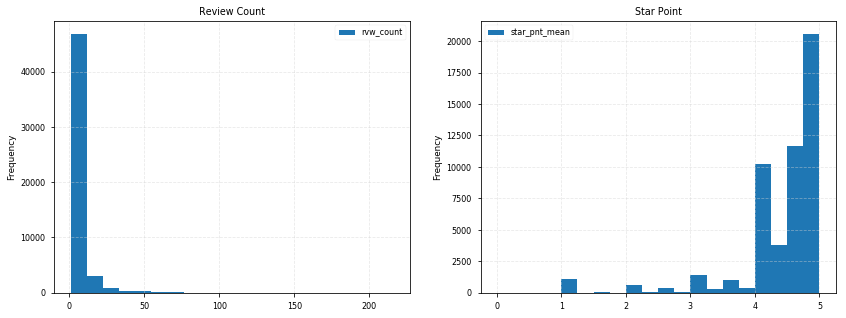

In [37]:
fig, ax = plt.subplots(1, 2)

shop_rvw['rvw_count'].plot(kind='hist', bins=20, ax=ax[0], figsize=(14,5))
shop_rvw['star_pnt_mean'].plot(kind='hist', bins=20, ax=ax[1])

ax[0].set_title("Review Count")
ax[0].legend()
ax[0].grid(color='lightgrey', alpha=0.5, linestyle='--')

ax[1].set_title("Star Point")
ax[1].legend()
ax[1].grid(color='lightgrey', alpha=0.5, linestyle='--')

### 3.4 즐겨찾기(좋아요) 등록갯수

```python
# 즐겨찾기 등록 추출 쿼리
shop_fav = spark.sql("""
                select
                    shop_no,
                    count(distinct mem_no) as fav_cnt
                from sbsvc.mem_favorite
                where reg_date >= '2018-03-22'
                    and reg_date < '2018-03-29'
                group by shop_no
                """)
```

In [38]:
shop_fav_tb = pd.read_csv("tb4_shop_fav.csv")

shop_fav_tb.head()

,shop_no,mem_no
0,414511,0
1,588306,0
2,603649,0
3,608427,0
4,610783,0


In [39]:
shop_fav_tb.tail()

,shop_no,mem_no
177474,747615,201408011668
177475,696088,201408011869
177476,684060,201408011885
177477,731729,201408011885
177478,731259,201408011965


In [40]:
print(shop_fav_tb['shop_no'].is_unique)
print(shop_fav_tb['mem_no'].is_unique)

False
False


In [41]:
# group by shop_no
shop_fav = shop_fav_tb.groupby("shop_no", as_index=False)['mem_no'].count()

shop_fav.columns = ['shop_no', 'fav_count']

shop_fav.head(10)

,shop_no,fav_count
0,120,13
1,425,1
2,530,1
3,598,1
4,851,1
5,1020,1
6,1369,4
7,1599,5
8,1626,3
9,1630,1


### 3.5 업소별 노출건수

```python
# 업소별 노출 쿼리
imps = spark.sql("""
                select 
                    log_dt, log_hour, event, JSON.*
                from (
                    select log_dt, log_hour, dvc_id, event_type, event,
                        explode(split(regexp_replace(regexp_replace(regexp_replace
                        (get_json_object(params, "$.Impressions")) as impression
                    from sblog.log_baemin_app
                    where log_dt >= '2018-03-22'
                        and log_dt < '2018-03-29'
                        and screen_name = 'Main'
                        and event_type = 'Event'
                        and env = 'RELEASE'
                        and event in ('CuraShopImp', 'PopShopImp')
                    )
                lateral view json_tuple(impression, "ShopNo", "position", "count") 
                JSON AS shop_no, position, count
                """)
```

In [42]:
shop_imps_tb = pd.read_csv("tb5_shop_imp.csv")

shop_imps_tb.head()

,shop_no,imps_cnt
0,713351.0,1723.0
1,702915.0,2356.0
2,736915.0,191.0
3,743282.0,220.0
4,703547.0,1853.0


In [43]:
shop_imps_tb.tail()

,shop_no,imps_cnt
3215,733529.0,131.0
3216,733467.0,2779.0
3217,576886.0,162.0
3218,653419.0,79.0
3219,681271.0,1513.0


In [44]:
shop_imps_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 2 columns):
shop_no     3219 non-null float64
imps_cnt    3206 non-null float64
dtypes: float64(2)
memory usage: 50.4 KB


In [45]:
shop_imps_tb.dropna(inplace=True)

In [46]:
shop_imps_tb['shop_no'] = shop_imps_tb['shop_no'].astype(int)
shop_imps_tb['imps_cnt'] = shop_imps_tb['imps_cnt'].astype(int)

In [47]:
shop_imps_tb.head()

,shop_no,imps_cnt
0,713351,1723
1,702915,2356
2,736915,191
3,743282,220
4,703547,1853


In [48]:
shop_imps_tb['shop_no'].is_unique

True

In [49]:
shop_imps = shop_imps_tb.copy()

### 3.6 업소별 클릭건수

```python
# 업소 클릭 로그 추출 쿼리
clk = spark.sql(""" 
                select
                    log_dt,
                    log_hour,
                    event,
                    dvc_id,
                    params
                from sblog.log_baemin_app
                where log_dt >= '2018-03-22' 
                    and log_dt < '2018-03-29'
                    and screen_name = 'Main'
                    and event_type = 'Click'
                    and event in ('ShopHorz', 'ShopVert', 'ShopFavorite')
                    and env = 'RELEASE'
                """)\
                .withColumn("shop_no", get_json_object("params", '$.ShopNo'))\
                .withColumn("position", get_json_object("params", '$.Position'))\
                .drop("params")

```                                                       

In [50]:
shop_clk_tb = pd.read_csv("tb6_shop_clk.csv")

shop_clk_tb.head()

,shop_no,clk_cnt
0,700426,33
1,696554,191
2,705288,3
3,654322,41
4,716725,5


In [51]:
shop_clk_tb.tail()

,shop_no,clk_cnt
3005,699160,6
3006,634141,3
3007,732239,4
3008,635432,4
3009,681335,1


In [52]:
shop_clk_tb['shop_no'].is_unique

True

In [53]:
shop_clk = shop_clk_tb.groupby("shop_no")['clk_cnt'].sum().reset_index()

shop_clk.head(10)

,shop_no,clk_cnt
0,36235,6
1,459193,156
2,522695,27
3,563770,13
4,563771,49
5,565051,42
6,565434,13
7,566297,8
8,566306,21
9,567009,65


In [54]:
shop_clk['shop_no'].is_unique

True

In [55]:
print(len(shop_imps))
print(len(shop_clk))

3206
3010


In [56]:
# 클릭율 추가
shop_imps_clk = shop_imps.merge(shop_clk, on="shop_no", how="left").fillna(0)
shop_imps_clk['ctr'] = (shop_imps_clk["clk_cnt"] / shop_imps_clk["imps_cnt"] * 100).round(3)

shop_imps_clk.head(10)

,shop_no,imps_cnt,clk_cnt,ctr
0,713351,1723,55.0,3.192
1,702915,2356,59.0,2.504
2,736915,191,5.0,2.618
3,743282,220,9.0,4.091
4,703547,1853,68.0,3.670
5,643372,258,2.0,0.775
6,710934,138,6.0,4.348
7,745881,236,6.0,2.542
8,683303,485,16.0,3.299
9,740549,1098,41.0,3.734


In [57]:
shop_imps_clk.describe().round()

,shop_no,imps_cnt,clk_cnt,ctr
count,3206.0,3206.0,3206.0,3206.0
mean,689038.0,1340.0,39.0,4.0
std,48333.0,1994.0,52.0,5.0
min,36235.0,1.0,0.0,0.0
25%,650775.0,198.0,7.0,2.0
50%,704617.0,638.0,21.0,3.0
75%,729803.0,1627.0,50.0,5.0
max,753688.0,34237.0,550.0,160.0


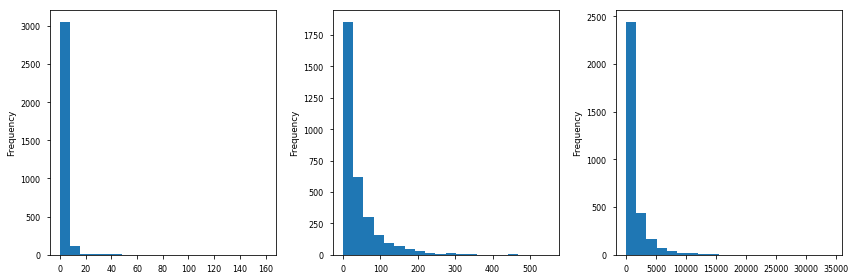

In [58]:
fig, ax = plt.subplots(1, 3)

shop_imps_clk.ctr.plot(kind='hist', ax=ax[0], bins=20, figsize=(12,4))
shop_imps_clk.clk_cnt.plot(kind='hist', ax=ax[1], bins=20)
shop_imps_clk.imps_cnt.plot(kind='hist', ax=ax[2], bins=20)

plt.tight_layout()

In [59]:
imps_cut = np.percentile(shop_imps_clk.imps_cnt, 25)
clk_cut = np.percentile(shop_imps_clk.clk_cnt, 25)

print(imps_cut, clk_cut)

(198.0, 7.0)


In [60]:
shop_imps_clk1 = shop_imps_clk.query("imps_cnt >= @imps_cut and clk_cnt >= @clk_cut")

shop_imps_clk1.head()

,shop_no,imps_cnt,clk_cnt,ctr
0,713351,1723,55.0,3.192
1,702915,2356,59.0,2.504
3,743282,220,9.0,4.091
4,703547,1853,68.0,3.670
8,683303,485,16.0,3.299


In [61]:
shop_imps_clk1.describe()

,shop_no,imps_cnt,clk_cnt,ctr
count,2303.000000,2303.000000,2303.000000,2303.000000
mean,692567.606166,1824.899696,53.038645,3.470778
std,45760.312578,2167.038629,55.123247,1.569238
min,459193.000000,198.000000,7.000000,0.476000
25%,657972.500000,532.000000,18.000000,2.346000
50%,707485.000000,1037.000000,34.000000,3.206000
75%,730973.000000,2241.500000,65.000000,4.266500
max,751528.000000,34237.000000,550.000000,13.380000


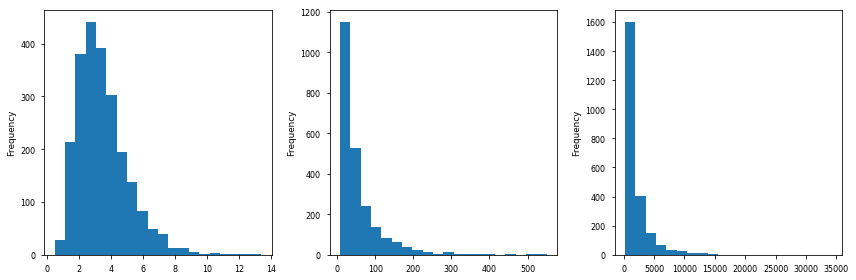

In [62]:
fig, ax = plt.subplots(1, 3)

shop_imps_clk1.ctr.plot(kind='hist', ax=ax[0], bins=20, figsize=(12,4))
shop_imps_clk1.clk_cnt.plot(kind='hist', ax=ax[1], bins=20)
shop_imps_clk1.imps_cnt.plot(kind='hist', ax=ax[2], bins=20)

plt.tight_layout()

### ✭ 추가 변수 탐색

### 3.7 업소별 객단가
- 객단가: 매출총액/주문건수
```python
pay_per_ord = spark.sql("""
                select
                    ord_no,
                    shop_no,
                    dvc_id,
                    ord_price,
                    ord_prog_cd,
                    ord_dt
                from sbtasty.tasty_ord 
                where ord_prog_cd = '2' 
                    and ord_dt >= '2018-03-01'
                    and ord_dt < '2018-03-29'
                """)\
                .filter("ord_cnt4 >= 10")\
                .withColumn("pay_per_ord", expr("round(ord_price / ord_cnt4, 0)"))\
                .drop("ord_price", "ord_cnt4")
```

In [63]:
# 주문건당 테이블
shop_ord_tb.head()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
0,TBJSVF018963,627879,OPUD9B95F362-69E0-495A-A920-6DCC0AED5989,9000,3,2018-03-28
1,TBIUZX013748,611777,OPUD2b10ee558d42a2a6,15900,2,2018-03-28
2,TBODPL001502,705469,OPUD77DD1E51-DF1F-4E1C-8A0E-CA2FCDDD9C70,55300,2,2018-03-28
3,TBKSLN013277,645203,OPUD6b4322f7a96bb571,12500,2,2018-03-28
4,TBLBZB012571,651639,OPUDFD52FBEA-10CA-4022-B283-AFB70BA0204C,23000,2,2018-03-28


In [64]:
# ord_prog_cd = 2 실 주문완료
ppo = shop_ord_tb.query("ord_prog_cd == '2'")\
                 .groupby("shop_no").agg({"ord_no": {"ord_no_cnt": "count"},
                                          "ord_price": {"ord_price_sum": "sum"}  
                                          }).reset_index()

ppo.columns = ppo.columns.get_level_values(1)
ppo = ppo.rename(columns = {"": "shop_no"}) 

ppo.head()

,shop_no,ord_price_sum,ord_no_cnt
0,36235,458000,15
1,459193,1009200,61
2,522695,1101000,62
3,563770,894000,75
4,563771,2700500,95


In [65]:
ord_no_cnt_cut = np.percentile(ppo.ord_no_cnt, 25)

ord_no_cnt_cut

5.0

In [66]:
ppo = ppo.query("ord_no_cnt >= @ord_no_cnt_cut")
ppo['ppo'] = (ppo['ord_price_sum'] / ppo['ord_no_cnt']).astype(int)

In [67]:
ppo.head(10)

,shop_no,ord_price_sum,ord_no_cnt,ppo
0,36235,458000,15,30533
1,459193,1009200,61,16544
2,522695,1101000,62,17758
3,563770,894000,75,11920
4,563771,2700500,95,28426
5,565051,550000,26,21153
6,565209,301800,24,12575
7,565434,118000,6,19666
8,566297,413000,10,41300
9,566306,869400,17,51141


In [68]:
ppo.describe().round(2)

,ord_price_sum,ord_no_cnt,ppo
count,2608.00,2608.00,2608.00
mean,621264.19,29.56,22411.86
std,646489.59,32.59,8037.37
min,57200.00,5.00,9555.00
25%,221700.00,10.00,17559.50
50%,406100.00,19.00,20533.50
75%,768950.00,36.00,25805.25
max,6807500.00,439.00,156500.00


### 3.8 업소당 주문 취소율
- 취소율: 취소건수/전체주문건수

In [69]:
shop_ord_tb.query("ord_prog_cd == 3").head()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
0,TBJSVF018963,627879,OPUD9B95F362-69E0-495A-A920-6DCC0AED5989,9000,3,2018-03-28
36,TBIHEB004373,602421,OPUDd277900c7ce70edf,15000,3,2018-03-28
91,TBIUZX013753,611777,OPUDae158ef3cd467718,20100,3,2018-03-28
92,TBIUZX013754,611777,OPUDc7fdc0442c4b1fc5,26000,3,2018-03-28
106,TBKKTH001806,639997,OPUD71C97B2C-F0FF-4391-97C4-01FE6F7EF0D8,8500,3,2018-03-28


In [70]:
# 업소당 취소건수
shop_ord_cncl = shop_ord_tb.query("ord_prog_cd == 3")\
                           .groupby("shop_no", as_index = False)['ord_no'].count()

# col name change
shop_ord_cncl.rename(columns = {'ord_no': 'ord_cncl_cnt'}, inplace=True)

shop_ord_cncl.head()

,shop_no,ord_cncl_cnt
0,459193,1
1,522695,1
2,563771,1
3,565209,3
4,568961,9


In [71]:
ppo_cncl = ppo.merge(shop_ord_cncl, on="shop_no", how="left").fillna(0)

ppo_cncl.head()

,shop_no,ord_price_sum,ord_no_cnt,ppo,ord_cncl_cnt
0,36235,458000,15,30533,0.0
1,459193,1009200,61,16544,1.0
2,522695,1101000,62,17758,1.0
3,563770,894000,75,11920,0.0
4,563771,2700500,95,28426,1.0


In [72]:
ppo_cncl['ord_cncl_rate'] = (ppo_cncl['ord_cncl_cnt'] / ppo_cncl['ord_no_cnt']).round(3)

ppo_cncl.head(10)

,shop_no,ord_price_sum,ord_no_cnt,ppo,ord_cncl_cnt,ord_cncl_rate
0,36235,458000,15,30533,0.0,0.000
1,459193,1009200,61,16544,1.0,0.016
2,522695,1101000,62,17758,1.0,0.016
3,563770,894000,75,11920,0.0,0.000
4,563771,2700500,95,28426,1.0,0.011
5,565051,550000,26,21153,0.0,0.000
6,565209,301800,24,12575,3.0,0.125
7,565434,118000,6,19666,0.0,0.000
8,566297,413000,10,41300,0.0,0.000
9,566306,869400,17,51141,0.0,0.000


### 3.9 업소당 재주문율
- 재주문율: 2회 이상 주문자수 / 전체 주문자수

In [73]:
shop_ord_tb.query("ord_prog_cd == '2'").head()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
1,TBIUZX013748,611777,OPUD2b10ee558d42a2a6,15900,2,2018-03-28
2,TBODPL001502,705469,OPUD77DD1E51-DF1F-4E1C-8A0E-CA2FCDDD9C70,55300,2,2018-03-28
3,TBKSLN013277,645203,OPUD6b4322f7a96bb571,12500,2,2018-03-28
4,TBLBZB012571,651639,OPUDFD52FBEA-10CA-4022-B283-AFB70BA0204C,23000,2,2018-03-28
5,TBLJLF006485,656687,OPUD6becd5a29901ab2b,26000,2,2018-03-28


In [74]:
# 업소별, 유저별 주문수 2회 이상 카운트
shop_reord = shop_ord_tb.query("ord_prog_cd == '2'")\
                        .groupby(["shop_no", "dvc_id"], as_index=False)['ord_no'].count()\
                        .query("ord_no >= 2")

shop_reord.head(10)

,shop_no,dvc_id,ord_no
19,459193,OPUD21a2260f9afa04de,2
21,459193,OPUD2ca7bd936f27b0d,3
46,459193,OPUD9C57D0FC-6DD7-4470-BF9C-2D1D3DB26D92,2
48,459193,OPUDA8158977-4CB2-4E7E-9B9B-F568553348A3,2
60,459193,OPUDa7a74ca84604edf6,2
134,563770,OPUD0DE46FD5-E47D-4E10-8527-6B18A3DB0135,2
173,563770,OPUD95d117447dc71432,2
200,563770,OPUDd4556f811aae7c8f,2
249,563771,OPUD7EA43077-B789-45FD-9F96-26548D614E0D,2
256,563771,OPUD93b14da776c644f8,2


In [75]:
# 업소별 재주문자수 카운트
shop_reord_by_shop = shop_reord.groupby("shop_no")['dvc_id'].count().reset_index()

shop_reord_by_shop.columns = ['shop_no', 'reord_dvc_cnt']

shop_reord_by_shop.head()

,shop_no,reord_dvc_cnt
0,459193,5
1,563770,3
2,563771,3
3,565209,1
4,567009,1


In [76]:
ppo_cncl_reord = ppo_cncl.merge(shop_reord_by_shop, on="shop_no", how="left").fillna(0)

ppo_cncl_reord.head(10)

,shop_no,ord_price_sum,ord_no_cnt,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt
0,36235,458000,15,30533,0.0,0.000,0.0
1,459193,1009200,61,16544,1.0,0.016,5.0
2,522695,1101000,62,17758,1.0,0.016,0.0
3,563770,894000,75,11920,0.0,0.000,3.0
4,563771,2700500,95,28426,1.0,0.011,3.0
5,565051,550000,26,21153,0.0,0.000,0.0
6,565209,301800,24,12575,3.0,0.125,1.0
7,565434,118000,6,19666,0.0,0.000,0.0
8,566297,413000,10,41300,0.0,0.000,0.0
9,566306,869400,17,51141,0.0,0.000,0.0


In [77]:
ppo_cncl_reord['reord_rate'] = (ppo_cncl_reord['reord_dvc_cnt'] / ppo_cncl_reord['ord_no_cnt']).round(3)

In [78]:
ppo_cncl_reord.head(10)

,shop_no,ord_price_sum,ord_no_cnt,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
0,36235,458000,15,30533,0.0,0.000,0.0,0.000
1,459193,1009200,61,16544,1.0,0.016,5.0,0.082
2,522695,1101000,62,17758,1.0,0.016,0.0,0.000
3,563770,894000,75,11920,0.0,0.000,3.0,0.040
4,563771,2700500,95,28426,1.0,0.011,3.0,0.032
5,565051,550000,26,21153,0.0,0.000,0.0,0.000
6,565209,301800,24,12575,3.0,0.125,1.0,0.042
7,565434,118000,6,19666,0.0,0.000,0.0,0.000
8,566297,413000,10,41300,0.0,0.000,0.0,0.000
9,566306,869400,17,51141,0.0,0.000,0.0,0.000


In [79]:
ppo_cncl_reord.drop("ord_no_cnt", axis=1, inplace=True)

In [80]:
ppo_cncl_reord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 0 to 2607
Data columns (total 7 columns):
shop_no          2608 non-null object
ord_price_sum    2608 non-null int64
ppo              2608 non-null int64
ord_cncl_cnt     2608 non-null float64
ord_cncl_rate    2608 non-null float64
reord_dvc_cnt    2608 non-null float64
reord_rate       2608 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 163.0+ KB


### 3.10 최종 테이블 (after join)
 - 업소별 기본 정보 테이블 
 - 업소별 주문 테이블
 - 업소별 리뷰 갯수 및 별점 평균
 - 업소별 즐겨찾기 등록수
 - 업소별 노출건수, 클릭건수, 클릭율
 - 업소별 객단가
 - 업소별 주문취소율 (negative)
 - 업소별 재주문율

In [81]:
# type matching for merge
shop_ord['shop_no'] = shop_ord['shop_no'].astype(int)
ppo_cncl_reord['shop_no'] = ppo_cncl_reord['shop_no'].astype(int)

In [82]:
df = shop.merge(shop_ord, on="shop_no", how="left")\
         .merge(shop_rvw, on="shop_no", how="left")\
         .merge(shop_fav, on="shop_no", how="left")\
         .merge(shop_imps_clk, on="shop_no", how="left")\
         .merge(ppo_cncl_reord, on="shop_no", how="left")

df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,NaN,296.0,6.0,2.027,458000.0,30533.0,0.0,0.000,0.0,0.000
1,39647,성남시 분당구,2010-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,6938.0,156.0,2.248,1009200.0,16544.0,1.0,0.016,5.0,0.082
3,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1739.0,27.0,1.553,1101000.0,17758.0,1.0,0.016,0.0,0.000
4,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,602.0,13.0,2.159,894000.0,11920.0,0.0,0.000,3.0,0.040


In [83]:
df.tail()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
3794,755746,강남구,2018-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3795,755775,강서구,2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3796,755777,양천구,2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3797,755779,강서구,2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3798,89915,부평구,2011-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 3798
Data columns (total 16 columns):
shop_no          3799 non-null int64
rgn2_nm          3799 non-null object
reg_dt           3799 non-null datetime64[ns]
ord_cnt          2974 non-null float64
rvw_count        1386 non-null float64
star_pnt_mean    1386 non-null float64
fav_count        2611 non-null float64
imps_cnt         2828 non-null float64
clk_cnt          2828 non-null float64
ctr              2828 non-null float64
ord_price_sum    2381 non-null float64
ppo              2381 non-null float64
ord_cncl_cnt     2381 non-null float64
ord_cncl_rate    2381 non-null float64
reord_dvc_cnt    2381 non-null float64
reord_rate       2381 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1), object(1)
memory usage: 504.6+ KB


### Q) ord_cnt 컬럼부터 끝 컬럼까지 모두 NaN인 경우 해당 행을 drop 해주세요.

In [87]:
myidx = df.loc[:,'ord_cnt':].dropna(how='all').index
df = df.ix[myidx].fillna(0).reset_index(drop=True)

In [88]:
df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,0.0,296.0,6.0,2.027,458000.0,30533.0,0.0,0.000,0.0,0.000
1,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,6938.0,156.0,2.248,1009200.0,16544.0,1.0,0.016,5.0,0.082
2,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1739.0,27.0,1.553,1101000.0,17758.0,1.0,0.016,0.0,0.000
3,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,602.0,13.0,2.159,894000.0,11920.0,0.0,0.000,3.0,0.040
4,563771,송파구,2015-05-13,95.0,2.0,5.0,6.0,3126.0,49.0,1.567,2700500.0,28426.0,1.0,0.011,3.0,0.032


In [89]:
df.tail()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
3210,752137,은평구,2018-03-21,3.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3211,752255,노원구,2018-03-22,9.0,2.0,4.5,1.0,193.0,11.0,5.699,168500.0,18722.0,0.0,0.0,0.0,0.0
3212,752519,성북구,2018-03-22,3.0,0.0,0.0,3.0,189.0,2.0,1.058,0.0,0.0,0.0,0.0,0.0,0.0
3213,753070,서초구,2018-03-23,2.0,1.0,5.0,1.0,84.0,1.0,1.190,0.0,0.0,0.0,0.0,0.0,0.0
3214,753688,고양시 일산동구,2018-03-26,0.0,0.0,0.0,0.0,186.0,16.0,8.602,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3215 entries, 0 to 3214
Data columns (total 16 columns):
shop_no          3215 non-null int64
rgn2_nm          3215 non-null object
reg_dt           3215 non-null datetime64[ns]
ord_cnt          3215 non-null float64
rvw_count        3215 non-null float64
star_pnt_mean    3215 non-null float64
fav_count        3215 non-null float64
imps_cnt         3215 non-null float64
clk_cnt          3215 non-null float64
ctr              3215 non-null float64
ord_price_sum    3215 non-null float64
ppo              3215 non-null float64
ord_cncl_cnt     3215 non-null float64
ord_cncl_rate    3215 non-null float64
reord_dvc_cnt    3215 non-null float64
reord_rate       3215 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1), object(1)
memory usage: 401.9+ KB


In [91]:
df['shop_no'] = df['shop_no'].astype(str)

## 4. 변수별 탐색 및 이해
- 변수별 분포
- 변수간 상관관계

In [92]:
print(len(df.shop_no))

3215


In [93]:
df.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,22.70,1.17,1.79,3.73,1201.60,34.95,3.23,468549.19,16659.12,0.65,0.03,0.87,0.03
std,30.91,2.34,2.16,4.89,1946.27,50.38,3.24,627676.13,12109.95,1.47,0.09,1.90,0.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,0.00,0.00,1.00,111.00,4.00,1.71,0.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,0.00,0.00,2.00,496.00,17.00,2.91,276200.00,18457.00,0.00,0.00,0.00,0.00
75%,29.00,1.00,4.00,5.00,1422.00,45.00,4.28,621900.00,23498.00,1.00,0.02,1.00,0.04
max,439.00,30.00,5.00,102.00,34237.00,550.00,100.00,6807500.00,156500.00,20.00,1.67,28.00,0.33


###  Outlier 제거가 맞을까? 제거한다면 그 업소의 점수는?

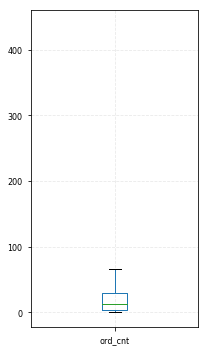

In [94]:
df['ord_cnt'].plot(kind='box', figsize=(3,5))

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

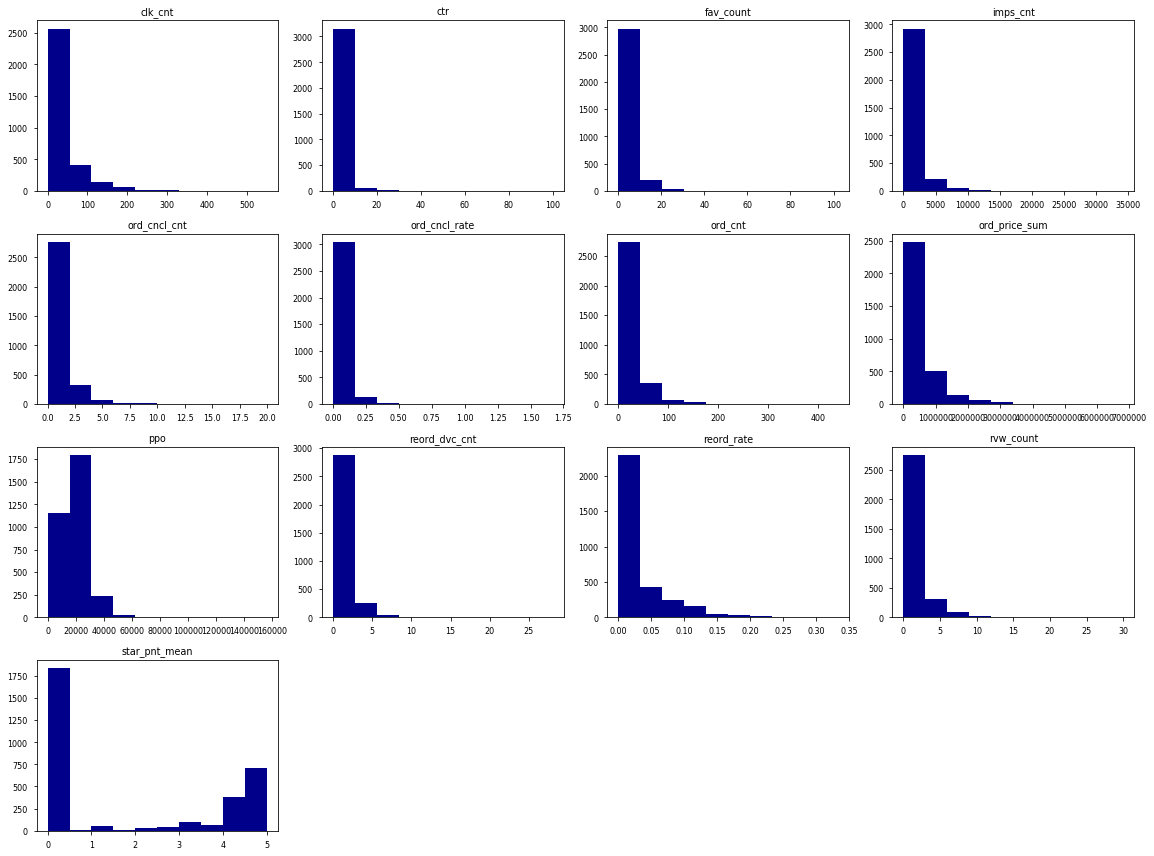

In [95]:
df.hist(color='darkblue', figsize=(16,12), grid=False);

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

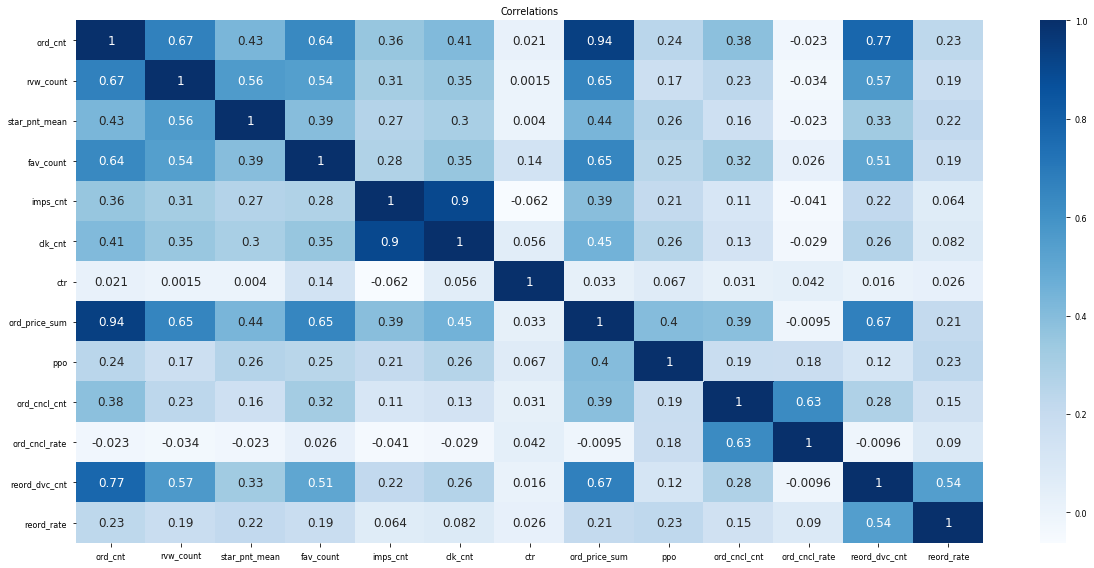

In [96]:
plt.subplots(figsize=(17,8))

sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.title("Correlations")
plt.tight_layout()

### Q) 적당한 방법으로 outlier 를 제거해보세요.

### Q) 컬럼을 모두 사용해야 할까요?? 일부만 한다면 어떤 컬럼을 써야할까요?

In [97]:
# drop cols
cols_to_drop = ['ord_price_sum', 'imps_cnt', 'clk_cnt', 'ord_cncl_cnt', 'reord_dvc_cnt']

df.drop(cols_to_drop, axis=1, inplace=True)

In [98]:
df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,0.0,2.027,30533.0,0.000,0.000
1,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,2.248,16544.0,0.016,0.082
2,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1.553,17758.0,0.016,0.000
3,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,2.159,11920.0,0.000,0.040
4,563771,송파구,2015-05-13,95.0,2.0,5.0,6.0,1.567,28426.0,0.011,0.032


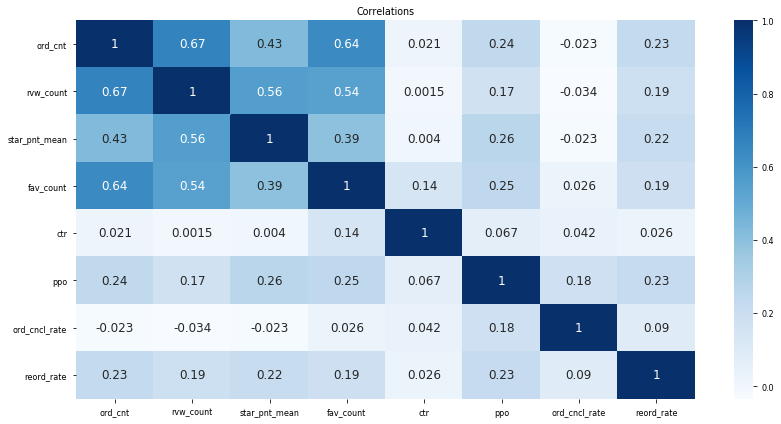

In [99]:
plt.subplots(figsize=(12,6))

sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.title("Correlations")
plt.tight_layout()

## 5. 스코어 계산

- 단순합은 어떨까?
- 단위를 어떻게 맞출까?

In [100]:
# Scaling
from sklearn import preprocessing

scaled_array = preprocessing.MinMaxScaler().fit_transform(df.loc[:, 'ord_cnt':])
score_scaled = pd.DataFrame(scaled_array, columns=df.loc[:,'ord_cnt':].columns)

score_scaled.head(10)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,0.034169,0.033333,1.0,0.000000,0.02027,0.195099,0.000000,0.000000
1,0.138952,0.033333,1.0,0.058824,0.02248,0.105712,0.009598,0.246246
2,0.141230,0.133333,1.0,0.039216,0.01553,0.113470,0.009598,0.000000
3,0.170843,0.066667,1.0,0.049020,0.02159,0.076166,0.000000,0.120120
4,0.216401,0.066667,1.0,0.058824,0.01567,0.181636,0.006599,0.096096
5,0.054670,0.000000,0.0,0.019608,0.00000,0.080351,0.074985,0.126126
6,0.013667,0.000000,0.0,0.009804,0.02534,0.125661,0.000000,0.000000
7,0.022779,0.000000,0.0,0.029412,0.01606,0.263898,0.000000,0.000000
8,0.038724,0.000000,0.0,0.029412,0.04861,0.326780,0.000000,0.000000
9,0.132118,0.033333,1.0,0.068627,0.03271,0.170703,0.000000,0.051051


In [101]:
score_scaled.describe()

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
count,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000
mean,0.051717,0.038880,0.357082,0.036566,0.032313,0.106448,0.018687,0.075581
std,0.070409,0.077937,0.432341,0.047977,0.032399,0.077380,0.051961,0.127710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009112,0.000000,0.000000,0.009804,0.017090,0.000000,0.000000,0.000000
50%,0.027335,0.000000,0.000000,0.019608,0.029090,0.117936,0.000000,0.000000
75%,0.066059,0.033333,0.800000,0.049020,0.042790,0.150147,0.014397,0.129129
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
df_scaled = pd.concat([df.loc[:,:'reg_dt'], score_scaled], axis=1)

df_scaled.head(10)

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,36235,관악구,2010-02-28,0.034169,0.033333,1.0,0.000000,0.02027,0.195099,0.000000,0.000000
1,459193,관악구,2013-01-30,0.138952,0.033333,1.0,0.058824,0.02248,0.105712,0.009598,0.246246
2,522695,강서구,2014-07-22,0.141230,0.133333,1.0,0.039216,0.01553,0.113470,0.009598,0.000000
3,563770,송파구,2015-05-13,0.170843,0.066667,1.0,0.049020,0.02159,0.076166,0.000000,0.120120
4,563771,송파구,2015-05-13,0.216401,0.066667,1.0,0.058824,0.01567,0.181636,0.006599,0.096096
5,565209,송파구,2015-05-22,0.054670,0.000000,0.0,0.019608,0.00000,0.080351,0.074985,0.126126
6,565434,송파구,2015-05-27,0.013667,0.000000,0.0,0.009804,0.02534,0.125661,0.000000,0.000000
7,566297,송파구,2015-06-01,0.022779,0.000000,0.0,0.029412,0.01606,0.263898,0.000000,0.000000
8,566306,송파구,2015-06-01,0.038724,0.000000,0.0,0.029412,0.04861,0.326780,0.000000,0.000000
9,567009,송파구,2015-06-05,0.132118,0.033333,1.0,0.068627,0.03271,0.170703,0.000000,0.051051


In [103]:
# positive to negative
df_scaled['ord_cncl_rate'] =  -1 * df_scaled['ord_cncl_rate']

In [104]:
df_scaled['score'] = df_scaled.sum(axis=1)

In [105]:
df_scaled.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,0.05,0.04,0.36,0.04,0.03,0.11,-0.02,0.08,0.68
std,0.07,0.08,0.43,0.05,0.03,0.08,0.05,0.13,0.62
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,-0.63
25%,0.01,0.00,0.00,0.01,0.02,0.00,-0.01,0.00,0.11
50%,0.03,0.00,0.00,0.02,0.03,0.12,-0.00,0.00,0.44
75%,0.07,0.03,0.80,0.05,0.04,0.15,-0.00,0.13,1.26
max,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,1.00,2.77


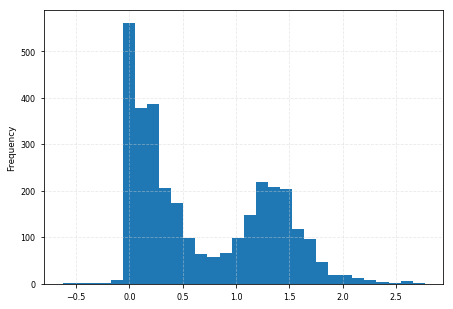

In [106]:
df_scaled['score'].plot(kind='hist', bins=30)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [107]:
## set weights
# ctr: 7
# ppo: 14
# ord_cncl_rate: 8
# reord_rate: 22

df_weight = df_scaled.drop("score", axis=1)

df_weight['ctr'] = df_weight['ctr'] * 7
df_weight['ppo'] = df_weight['ppo'] * 14
df_weight['ord_cncl_rate'] = df_weight['ord_cncl_rate'] * 8
df_weight['reord_rate'] = df_weight['reord_rate'] * 22

df_weight['score'] = df_weight.sum(axis=1)
df_weight.sort_values("score", ascending=False, inplace=True)

In [108]:
df_weight.head(10)

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
1920,716445,성남시 분당구,2017-11-13,0.013667,0.000000,0.00,0.009804,0.29848,4.337137,-0.000000,22.000000,26.659089
1888,715580,중구,2017-11-09,0.027335,0.033333,0.80,0.029412,0.27874,2.228192,-0.398320,22.000000,24.998691
2219,726226,부천시,2017-12-14,0.015945,0.033333,1.00,0.058824,0.08568,2.045968,-0.000000,18.894895,22.134645
1852,714427,동작구,2017-11-06,0.013667,0.000000,0.00,0.009804,0.15799,0.885623,-1.598080,22.000000,21.469004
15,571725,강남구,2015-07-08,0.043280,0.000000,0.00,0.039216,0.39438,1.587591,-1.012597,17.375375,18.427245
262,613364,강남구,2016-03-20,0.011390,0.033333,1.00,0.029412,0.00000,3.936102,-0.000000,13.213213,18.223450
1974,718222,도봉구,2017-11-17,0.011390,0.033333,1.00,0.000000,0.13531,3.470927,-0.000000,13.213213,17.864173
3038,743549,수원시 영통구,2018-02-20,0.020501,0.133333,0.65,0.049020,0.16527,1.765252,-0.000000,14.666667,17.450043
1365,692685,강남구,2017-08-07,0.020501,0.000000,0.00,0.068627,0.37632,2.773163,-0.532693,14.666667,17.372585
2763,737724,종로구,2018-01-24,0.020501,0.000000,0.00,0.000000,0.14931,2.342696,-0.000000,14.666667,17.179174


In [109]:
df_weight.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,0.05,0.04,0.36,0.04,0.23,1.49,-0.15,1.66,3.71
std,0.07,0.08,0.43,0.05,0.23,1.08,0.42,2.81,3.43
min,0.00,0.00,0.00,0.00,0.00,0.00,-8.00,0.00,-4.34
25%,0.01,0.00,0.00,0.01,0.12,0.00,-0.12,0.00,0.93
50%,0.03,0.00,0.00,0.02,0.20,1.65,-0.00,0.00,2.85
75%,0.07,0.03,0.80,0.05,0.30,2.10,-0.00,2.84,5.65
max,1.00,1.00,1.00,1.00,7.00,14.00,-0.00,22.00,26.66


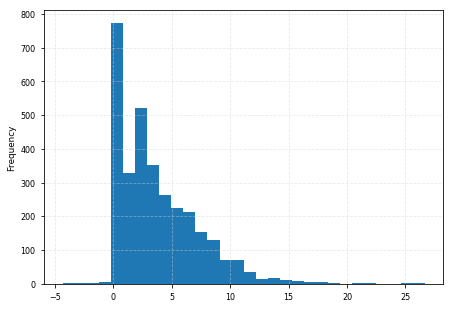

In [110]:
# 전체 지역
df_weight['score'].plot(kind='hist', bins=30)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

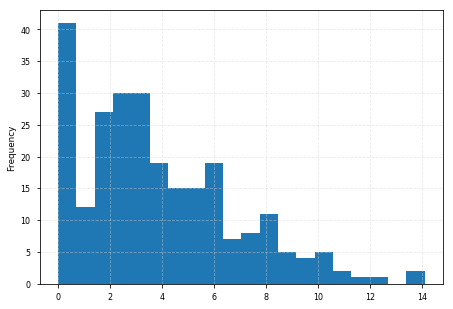

In [111]:
# 특정 지역
df_weight.query("rgn2_nm == '송파구'")['score'].plot(kind='hist', bins=20)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [112]:
df_weight.query("rgn2_nm == '송파구'")[:10]

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948
10,567365,송파구,2015-06-08,0.027335,0.033333,0.800000,0.019608,0.81396,3.444089,-0.000000,5.483483,10.621809
886,656463,송파구,2017-01-12,0.054670,0.066667,0.800000,0.019608,0.06510,1.484179,-0.201560,8.258258,10.546922
820,652644,송파구,2016-12-20,0.020501,0.033333,0.200000,0.029412,0.12334,2.773163,-0.000000,7.333333,10.513083
91,594320,송파구,2015-11-24,0.095672,0.100000,1.000000,0.029412,0.18669,1.471744,-0.340732,7.861862,10.404648
2604,734362,송파구,2018-01-12,0.129841,0.200000,0.900000,0.166667,0.30261,1.564958,-0.000000,6.936937,10.201013


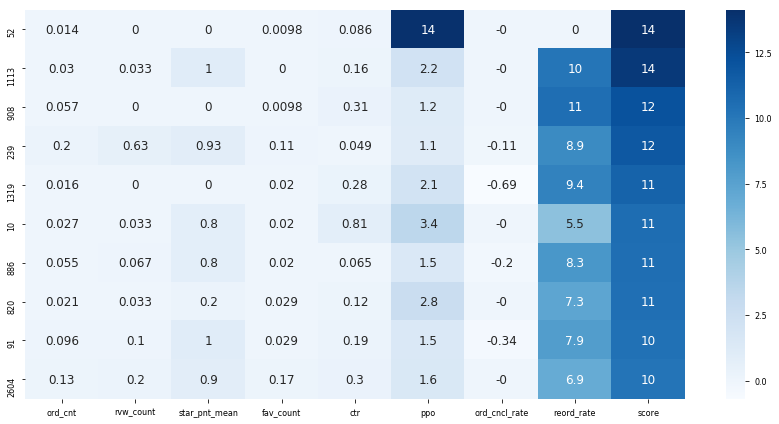

In [115]:
plt.subplots(figsize=(12,6))

sns.heatmap(df_weight.query("rgn2_nm == '송파구'").loc[:,'ord_cnt':][:10], annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.tight_layout()

### Q) 다른 가중치를 적용하여 보세요. 적당한 결과를 보이는 가중치는 무엇일까요?

## 6. 성과 측정
- [검색 랭킹 Evaluation](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)
    - Online Metric (based on users' interactions)
        - Click Through Rate 
        - Conversion Rate
        - Zero-result Rate
    - Offline Metric (based on relevance)
        - Average Precision
        - Precision At K
        - Mean Average Precision
        - [NDCG (Normalized Discounted Cumulative Gain)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)
- **최종 선정 지표(Metric)**
    - CTR: 클릭 / 노출 * 100
    - 주문율: 주문 / 클릭 * 100
    - 포지션별 클릭수, 주문수
    - NDCG

In [116]:
# 업소별 노출건수
metric_imp = pd.read_csv("tb7_imp_by_shop.csv").fillna(0)

In [117]:
metric_imp.head()

,log_dt,shop_no,count_sum,viewcount_sum
0,2018-04-01,703463,130.0,120.0
1,2018-04-01,669093,147.0,208.0
2,2018-04-01,612470,248.0,121.0
3,2018-04-01,752255,185.0,136.0
4,2018-04-01,627854,47.0,37.0


In [118]:
metric_imp.tail()

,log_dt,shop_no,count_sum,viewcount_sum
17183,2018-04-05,745039,5.0,0.0
17184,2018-04-05,653188,2.0,3.0
17185,2018-04-03,628092,0.0,1.0
17186,2018-04-01,721292,2.0,0.0
17187,2018-04-02,718066,4.0,0.0


In [119]:
metric_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17188 entries, 0 to 17187
Data columns (total 4 columns):
log_dt           17188 non-null object
shop_no          17188 non-null int64
count_sum        17188 non-null float64
viewcount_sum    17188 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 537.2+ KB


In [120]:
metric_imp['imp_total'] = metric_imp['count_sum'] + metric_imp['viewcount_sum'] 

In [121]:
metric_imp.head()

,log_dt,shop_no,count_sum,viewcount_sum,imp_total
0,2018-04-01,703463,130.0,120.0,250.0
1,2018-04-01,669093,147.0,208.0,355.0
2,2018-04-01,612470,248.0,121.0,369.0
3,2018-04-01,752255,185.0,136.0,321.0
4,2018-04-01,627854,47.0,37.0,84.0


In [122]:
metric_imp.tail()

,log_dt,shop_no,count_sum,viewcount_sum,imp_total
17183,2018-04-05,745039,5.0,0.0,5.0
17184,2018-04-05,653188,2.0,3.0,5.0
17185,2018-04-03,628092,0.0,1.0,1.0
17186,2018-04-01,721292,2.0,0.0,2.0
17187,2018-04-02,718066,4.0,0.0,4.0


In [123]:
metric_imp.groupby("log_dt")['imp_total'].sum()

log_dt
2018-04-01    485360.0
2018-04-02    257963.0
2018-04-03    264291.0
2018-04-04    250998.0
2018-04-05    390809.0
2018-04-06    385282.0
2018-04-07    425143.0
Name: imp_total, dtype: float64

In [124]:
# 업소별 클릭건수
metric_clk = pd.read_csv("tb8_clk_by_shop.csv").fillna(0)

metric_clk.head()

,log_dt,shop_no,position,clk_cnt
0,2018-04-01,744861,0,1
1,2018-04-01,707408,4,1
2,2018-04-01,739030,1,8
3,2018-04-01,730400,2,3
4,2018-04-01,644976,2,7


In [125]:
metric_clk.groupby("log_dt")['clk_cnt'].sum()

log_dt
2018-04-01    11258
2018-04-02     4917
2018-04-03     5435
2018-04-04     5156
2018-04-05     8219
2018-04-06     7904
2018-04-07    10124
Name: clk_cnt, dtype: int64

In [126]:
daily_imp = metric_imp.groupby("log_dt")['imp_total'].sum()
daily_clk = metric_clk.groupby("log_dt")['clk_cnt'].sum()

In [127]:
daily_metric = pd.concat([daily_imp, daily_clk], axis=1)

daily_metric

,imp_total,clk_cnt
log_dt,,
2018-04-01,485360.0,11258
2018-04-02,257963.0,4917
2018-04-03,264291.0,5435
2018-04-04,250998.0,5156
2018-04-05,390809.0,8219
2018-04-06,385282.0,7904
2018-04-07,425143.0,10124


In [128]:
daily_metric['ctr'] = (daily_metric['clk_cnt'] / daily_metric['imp_total'] * 100).round(3)

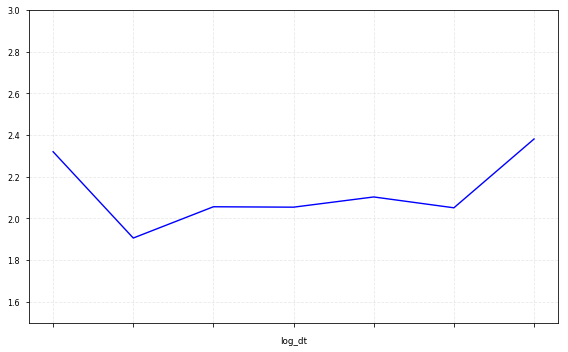

In [129]:
daily_metric['ctr'].plot(figsize=(8,5), color='blue')

plt.ylim(1.5, 3)
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

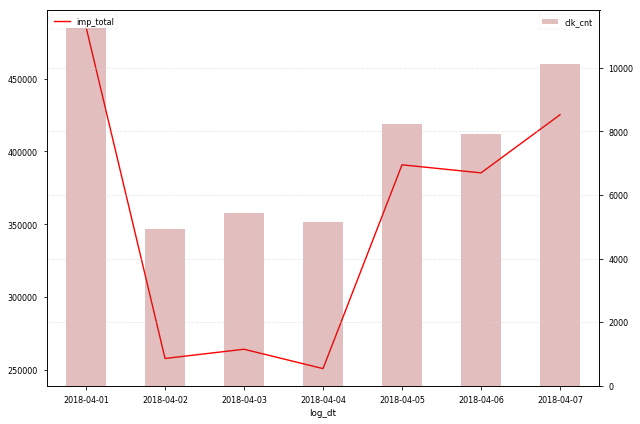

In [130]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)
daily_metric['imp_total'].plot(color='red')

ax2 = ax.twinx()
daily_metric['clk_cnt'].plot(kind='bar', color='brown', alpha=0.3)

ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [131]:
# 주문율 생략

In [132]:
# 포지션별 클릭 및 주문
metric_clk.head()

,log_dt,shop_no,position,clk_cnt
0,2018-04-01,744861,0,1
1,2018-04-01,707408,4,1
2,2018-04-01,739030,1,8
3,2018-04-01,730400,2,3
4,2018-04-01,644976,2,7


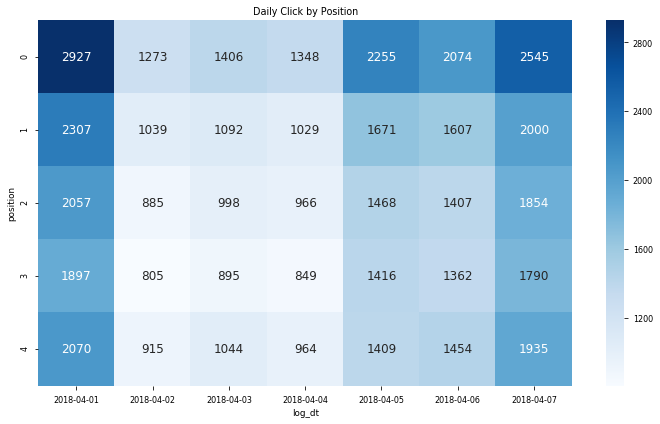

In [133]:
plt.subplots(figsize=(10,6))

sns.heatmap(metric_clk.groupby(["log_dt", "position"])['clk_cnt'].sum().unstack(level=0),\
            annot=True, annot_kws={"size": 12}, cmap='Blues', fmt='g');

plt.title("Daily Click by Position")
plt.tight_layout()

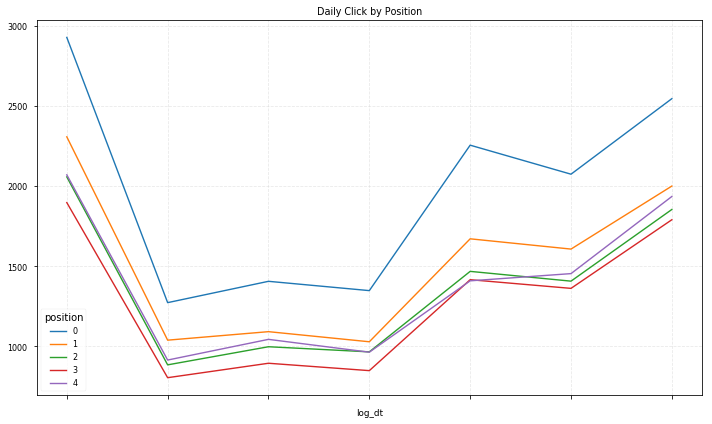

In [134]:
metric_clk.groupby(["log_dt", "position"])['clk_cnt'].sum().unstack().plot(figsize=(10,6))

plt.title("Daily Click by Position")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [135]:
# NDCG (Normalized Discounted Cumulative Gain)
# reference: https://en.wikipedia.org/wiki/Discounted_cumulative_gain)

metric_clk.head()

,log_dt,shop_no,position,clk_cnt
0,2018-04-01,744861,0,1
1,2018-04-01,707408,4,1
2,2018-04-01,739030,1,8
3,2018-04-01,730400,2,3
4,2018-04-01,644976,2,7


In [136]:
metric_clk['position_log'] = np.log2((metric_clk['position'] + 2)).round(3)

In [137]:
metric_clk.head()

,log_dt,shop_no,position,clk_cnt,position_log
0,2018-04-01,744861,0,1,1.000
1,2018-04-01,707408,4,1,2.585
2,2018-04-01,739030,1,8,1.585
3,2018-04-01,730400,2,3,2.000
4,2018-04-01,644976,2,7,2.000


In [138]:
metric_clk['clk_by_position'] = (metric_clk['clk_cnt'] / metric_clk['position_log']).round(3)

In [139]:
metric_clk.head(10)

,log_dt,shop_no,position,clk_cnt,position_log,clk_by_position
0,2018-04-01,744861,0,1,1.000,1.000
1,2018-04-01,707408,4,1,2.585,0.387
2,2018-04-01,739030,1,8,1.585,5.047
3,2018-04-01,730400,2,3,2.000,1.500
4,2018-04-01,644976,2,7,2.000,3.500
5,2018-04-01,704937,4,3,2.585,1.161
6,2018-04-01,715557,0,3,1.000,3.000
7,2018-04-01,609506,0,2,1.000,2.000
8,2018-04-02,737652,0,1,1.000,1.000
9,2018-04-02,739474,4,3,2.585,1.161


In [140]:
ndcg = metric_clk.groupby("log_dt")['clk_by_position'].describe()

ndcg

,count,mean,std,min,25%,50%,75%,max
log_dt,,,,,,,,
2018-04-01,5071.0,1.386153,1.358476,0.387,0.500,1.000,1.893,17.0
2018-04-02,3232.0,0.950491,0.757995,0.387,0.431,0.631,1.000,9.0
2018-04-03,3511.0,0.963715,0.805798,0.387,0.431,0.631,1.000,9.0
2018-04-04,3386.0,0.950707,0.774461,0.387,0.431,0.631,1.000,9.0
2018-04-05,4738.0,1.097210,0.968391,0.387,0.500,0.774,1.262,15.0
2018-04-06,4464.0,1.106816,0.983000,0.387,0.500,0.861,1.262,10.0
2018-04-07,5274.0,1.185762,1.105772,0.387,0.500,0.861,1.292,19.0


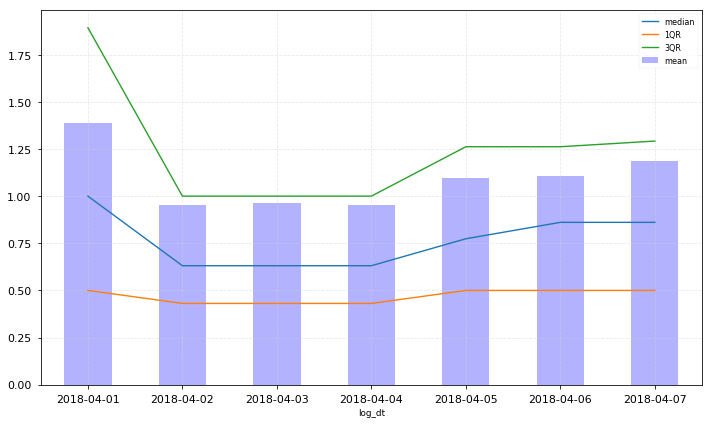

In [141]:
plt.subplots(figsize=(10,6))

ndcg['mean'].plot(label='mean', kind='bar', color='blue', alpha=.3, fontsize=11)
ndcg['50%'].plot(label='median')
ndcg['25%'].plot(label='1QR')
ndcg['75%'].plot(label='3QR')

plt.legend()
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

## 7. 로직 고도화
- New & Rising 쿼터 조건 => PASS
- 신규 변수 추가 => PASS
    - 리뷰 텍스트마이닝 & 감성분석 => PASS
- **[개인화 추천 로직](http://khanrc.tistory.com/entry/%EC%B6%94%EC%B2%9C-%EC%8B%9C%EC%8A%A4%ED%85%9CRecommendation-System)**
    - [Contents-based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
    - [Collaborative Filtering](https://en.wikipedia.org/wiki/Recommender_system#Collaborative_filtering)
    - Baseline
    - Matrix factorization
- **[A/B Testing](https://www.optimizely.com/optimization-glossary/ab-testing/)**
- **사용자 설문**

### 7.1 Contents-based Filtering (Prototyping)
- popularity-based recommand engine은 일괄적으로 동일한 랭크를 보여주기 때문에 개인의 취향이 고려되지 않은 단점을 지님
- contents(업소 태그 정보)를 이용해 업소간 유사도를 구해, **유저가 가장 선호하는 업소**와 유사한 업소를 먼저 추천해주는 방식 채택
    - 유저가 선호하는 업소의 기준?
        - 2회 이상 주문한 업소
        - 5회 이상 클릭한 업소
        - 좋아요 혹은 즐겨찾기 등록업소
        - 별점을 높게 준(x점 이상) 업소
        - 리뷰 혹은 업소상세 화면을 상세히 읽은 (x초 이상 체류) 업소
        - ....

- Dataset
    - tb9_shop_tag.csv: 업소별 지역 및 contents(tags) 정보
- Framework
    - 전처리 및 추출 (생략)
    - 태그 이용해 tf-idf 적용 -> 매트릭스 생성
    - Cosine Similarity 도출
    - 추천 결과 생성을 위한 함수 생성

In [142]:
# 업소별 태그 정보
shop_tag = pd.read_csv("tb9_shop_tag.csv")

In [143]:
shop_tag.head()

,shop_no,rgn2_nm,content
0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [144]:
shop_tag.tail()

,shop_no,rgn2_nm,content
5744,787681,강남구,"한식, NEW, 삼계탕, 닭도리탕"
5745,789188,강서구,NaN
5746,791217,관악구,"고기, 한식, NEW, 뼈해장국, 순대국"
5747,795129,송파구,NaN
5748,799581,용산구,NaN


In [145]:
# no content shops
#shop_tag.query("content == np.NaN").groupby("rgn2_nm").size().sort_values(ascending=False)[:10]

shop_tag_null = shop_tag[pd.isnull(shop_tag).any(axis=1)]

shop_tag_null.head()

,shop_no,rgn2_nm,content
13,724416,고양시 일산동구,NaN
30,793144,마포구,NaN
33,798148,강북구,NaN
34,798809,강남구,NaN
35,799102,용산구,NaN


In [146]:
shop_tag_null.groupby("rgn2_nm").size().sort_values(ascending=False)[:10]

rgn2_nm
중구         100
강남구         80
송파구         24
관악구         23
마포구         21
용산구         21
성남시 분당구     19
종로구         19
부천시         17
강동구         16
dtype: int64

In [147]:
# shops with content
shop_tag = shop_tag.dropna()

shop_tag.head()

,shop_no,rgn2_nm,content
0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [148]:
shop_tag.tail()

,shop_no,rgn2_nm,content
5740,768540,노원구,"일식·회, 참치회, 참치초밥"
5741,771501,중랑구,"일식·회, NEW, 초밥, 회덮밥"
5742,775560,동작구,"한식, NEW, 보리새우매운탕, 한끼식사되는, 매콤, 해산물덕후, 속이풀리는, 향이..."
5744,787681,강남구,"한식, NEW, 삼계탕, 닭도리탕"
5746,791217,관악구,"고기, 한식, NEW, 뼈해장국, 순대국"


In [149]:
shop_tag.groupby("rgn2_nm").size().sort_values(ascending=False)[:10]

rgn2_nm
강남구        763
송파구        345
관악구        343
용산구        296
서초구        291
마포구        258
동작구        193
강서구        182
영등포구       171
성남시 분당구    161
dtype: int64

In [150]:
shop_tag_null_compare = pd.concat([shop_tag_null.groupby("rgn2_nm").size().sort_values(ascending=False),\
                                   shop_tag.groupby("rgn2_nm").size().sort_values(ascending=False)], axis=1)

shop_tag_null_compare.columns = ['tag_null', 'tag_have']

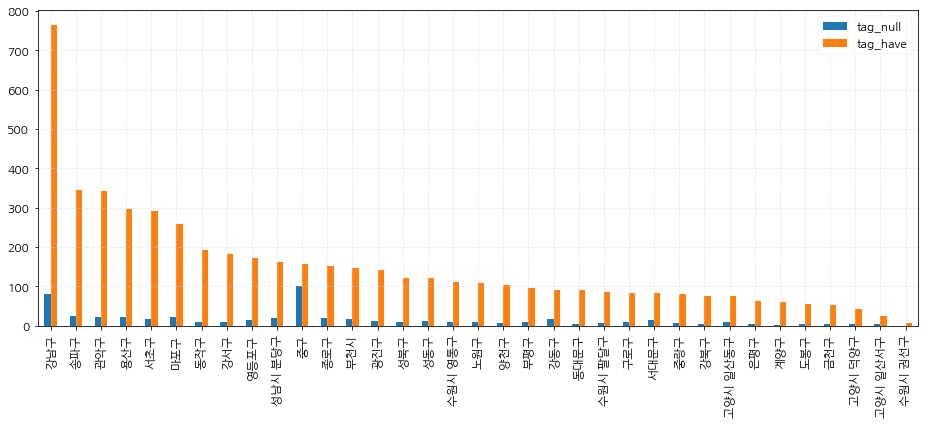

In [151]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/Users/woowahan/Library/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

shop_tag_null_compare.sort_values("tag_have", ascending=False).plot(kind='bar', figsize=(13,6), fontsize=12)

plt.legend(fontsize=12)
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### Reference
- https://blog.breezymind.com/2018/03/02/sklearn-feature_extraction-text/

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tf = TfidfVectorizer()
# tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(shop_tag['content'])

### [TF-IDF](https://ko.wikipedia.org/wiki/Tf-idf)
- [Reference](https://thinkwarelab.wordpress.com/2016/11/14/ir-tf-idf-%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B4%85%EC%8B%9C%EB%8B%A4/)
- Term Frequency - Inverse Document Frequency)
![img](tfidf.png)

In [153]:
tfidf_matrix.toarray().shape

(5221, 7693)

In [154]:
print(tfidf_matrix.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.13880246 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [155]:
shop_tag.shape

(5221, 3)

In [156]:
for term in tf.get_feature_names():
    print (term)

100
100매운치즈돈까스
100순메밀막국수
1개
1등급한우미트볼에그베네딕트
1리터아메리카노
1월의딸기난샐러드
1인닭갈비덮밥
1인메뉴
1인벤또사이드세트
1인벤또새우튀김세트
1인보쌈도시락
1인샐러드세트
1인세트
1인족발
24시간영업
24시영업
25겹카츠일본카레덮밥
2개
2인벤또고로케세트
2인분
2인용platters풀드포크
2인피크닉세트
30cm독일수제소세지핫도그
30cm왕돈가스
3代시래기국
3가지구운버섯샐러드
3가지버섯피자
3대시래기도시락
3대째
3시래기국도시락
4가지치즈피자
4인모둠
50cm바게트브릿지
50센치바게트브릿지
5징어떡볶이
5징어짬뽕탕
742898
8090
88고추튀김
88김치삼겹두루치기
88배이컨치즈버거
88함박스테끼
88홍합짬뽕
a17스프링롤
a3특선모듬전식
azemix
a사시미
bbburger
bbq버거
bbq치즈밤
bbq포크부리또
bbq폴드포크샌드위치
bb스테이크
belt샌드위치
blt
blte샌드위치
blt샌드위치
boiledseafood
b코스
call911버거
chickenbriyani치킨비리아니
chilicheesefries
cholebhature촐레바투레
crf프라임필렛미뇽
dang
dearsophie2
gethealthy샐러드
greendetox
hola
hot오리지날밀크티
ice소금커피
is바삭모둠도시락
jin
jvl부대찌개
la갈비
la갈비구이
makhni치킨마크니
man
memphisburger
n3사천해산물팟타이
n4해산물팟타이
never롱볶이
never알감자
new
p1얇게썬홍두깨쌀국수
p2잘익힌양지쌀국수
p3잘익힌양지
plainnaan플레인난
r3파인애플새우볶음밥
r3하노이볶음밥
r8톰양볶음밥
r9숯불구이볶음밥
real자몽주스
s1해산물볶음쌀국수
s2해산물팟타이
semifive
shrimpbucket
special특모둠
spicy아마트리치아나
theboss
tov버거
tv맛집
tv맛집맛대맛
v1월남쌈
vip플러스주먹밥
火쭈꾸미
生연어회
生홍두개쌀국수
生홍두깨쌀국수
生홍두깨와양지차돌박이쌀국수
辛얼큰버섯순대국
辛쭈꾸미
가격이

루꼴라
루꼴라샌드위치
루꼴라소고기
루꼴라와새우파스타
루꼴라피자
루꼴라피자세트
루스틱앙버터
루이보스레몬
루키버거
루터버거
리가토니
리빈토스트
리얼갈릭스테이크
리얼딸기우유
리얼레몬티
리얼베이컨포테이토피자
리얼초코머랭쿠키
리조또
리조또마레토마토
리치골드피자
리치자스민티
리코즉석떡볶이
리코타가지리가토니
리코타샌드위치
리코타샐러드
리코타청포도샐러드
리코타치즈샌드위치
리코타치즈샐러드
리코타치즈피자
리코타토스타다
리코타토스타다샐러드
리코타플러스허니멜팅샌드위치
립샌드위치
립아이스테이크
립아이스테이크와라이스
링귀네루꼴라감베리
링귀네페스카또레
마가리타
마끼아또
마녀김밥
마녀떡볶이
마늘간장치킨
마늘갈비찜
마늘고추새우
마늘돈가스
마늘돈까스
마늘돼지갈비구이
마늘돼지고기쭈꾸미
마늘등갈비
마늘등심탕수육
마늘떡볶이
마늘바게트
마늘버터깔라마리셀박
마늘보쌈
마늘볶음밥
마늘빵
마늘삼겹살
마늘소금닭갈비
마늘스테이크덮밥
마늘육회
마늘치킨벤또
마늘카츠
마늘황소곱창
마라
마라가재
마라롱샤
마라반
마라반반
마라상궈
마라샤우룽샤
마라샹궈
마라소롱샤
마라탕
마라탕쌀국수
마라항궈
마레스파이시파스타
마레토마토리조또세트
마레토마토파스타
마롱깜빠뉴
마롱체커스
마르게리따
마르게리따콘부팔라
마르게리따피자
마르게리따피자프리미엄
마르게리타
마마스보울샐러드
마마통살버거
마블함박스테이크
마뽕
마사탓스
마살라라이스
마스카포네케이크
마스카포네허니초코
마약김밥
마약마늘소스파닭
마약불고기
마약옥수수
마약주먹밥
마약찜닭
마약콘치즈
마약핫도그
마요덮밥
마요새우
마요쉬림프
마운트한라롤
마음껏버섯
마카로니콥샐러드
마카롱
마카롱빙수
마카롱코코
마카롱프라페
마카이팔락큼부커리
마키아티
마파가지밥
마파두부
마파두부덮밥
막걸리
막국수
막창
막창구이
막창소금
막창소금구이
막창양념
막창양념구이
막회
막회비빔밥
만두
만두국
만두버섯전골
만두새우탕
만두설렁탕
만두육개장
만두전골
만두튀김
만두한접시
만두한판
만두해장국
만둣국
만조로제파스타
만조샐러드
만조크림파스타
만쥬
만진당샐러드
말고기육회
말린스
말복
말차두유
말차라떼
말차밀크티
말차브라우니
말차빙수


뼈다귀해장국
뼈닭발
뼈닭찜
뼈없는닭갈비
뼈없는닭발
뼈없는불닭발
뼈없는찜닭
뼈전골
뼈찜
뼈해장국
뼈해장국정식
뼛국
뼛찜
뽀글이닭발
뽀모도로
뽀모도르
뽀삐아
뽈대구전골
뽈로감베리로제파스타
뽈로샐러드
뽈로필라프
뽈살순대국
뽈찜
뽕밥
뽕족발
뿌님팟퐁거리
뿌님팟퐁까리
뿌님팟퐁커리
뿌빳뽕커리
뿌팟봉커리
뿌팟뽕커리
뿌팟퐁커리
쁘띠카네이션
삑까이텃
사골감자탕
사골곰탕
사골떡만두국
사골만두국
사골만두국밥
사골만두육개장
사골설렁탕
사골순대국
사골우거지들깨탕
사골우거지탕
사골우거지해장국
사골육개장
사과오렌지주스
사과주스
사과쥬스
사누끼우동
사라다빵
사르르녹는
사리넣어먹으면맛있는
사리넣으면맛있는
사모사
사몬동
사무실
사보텐정식
사시미
사시미모듬
사시미벤또
사시미와사비샐러드
사시사철
사우어치즈타르트
사이공볶음면
사이공볶음밥
사장님국밥
사조스페셜
사천볶음쌀국수
사천식닭날개
사천식돼지고기튀김
사천식소프트크랩튀김
사천식쌀국수
사천식잡채덮밥
사천식포크
사천식홍합볶음
사천치킨
사천포크
사천해산물팟타이
사케동
사케동셋트
사케사시미
사포나리아스무디
산고등어
산꼼장어
산나물
산나물보쌈
산나물정식
산낙육회
산낙지
산낙지볶음
산낙지연포탕
산낙지육회탕탕
산낙지전복물갈비
산낙지탕탕이
산낙지회
산딸기가나슈
산딸기민트라떼
산딸기치즈케익
산삼갈비탕
산삼삼계탕
산아나고
산오징어회
산채김밥
산채냉면
산채메밀왕만두
산채보쌈
살라미
살라미샌드위치
살라미치즈샌드위치
살라미파니니
살라미플레이트
살라미피자
살라미햄시카고피자
살로만
살몬이시즈시
살몬하모니샐러드
살살녹는문푸딩
살치살덮밥
살치살스테이크
살코기순대국정식
삶은고기
삼각샌드위치
삼겹
삼겹구이덮밥
삼겹김치덮밥
삼겹김치찌개
삼겹도시락
삼겹두루치기
삼겹두부김치
삼겹부대볶음
삼겹살
삼겹살구이
삼겹살김밥
삼겹살김치볶음컵밥
삼겹살김치컵밥
삼겹살덮밥
삼겹살데리야끼
삼겹살두루치기
삼겹살두부김치
삼겹살부대볶음
삼겹살비빔덮밥
삼겹살수육
삼겹살스테이크
삼겹살정식
삼겹살쭈꾸미
삼겹살쭈꾸미철판
삼겹살찌개혜자세트
삼겹살플레이트
삼겹숙주볶음
삼겹순대국
삼겹스테이크
삼겹양념구이
삼겹양념정식
삼

철판볶음밥
철판불고기
철판불고기덮밥
철판삼겹숙주볶음
철판삼겹쭈꾸미
철판순대곱창
철판순대볶음
철판야키소바
철판양념족발
철판요리
철판장조림버터비빔밥
철판제육덮밥
철판쭈꾸미
철판쭈꾸미삼겹살
철판쭈삼겹
철판치즈곱창
철판치즈김치볶음밥
철판치즈닭갈비덮밥
청국장
청년돈까스
청춘짜장
청포도라임모히또
청포도리코타치즈샐러드
청포도스무디
청포도에이드
청포도타르트
체다치즈푸틴
초계국수
초계냉쌀국수
초계비빔국수
초리소타코
초바
초바생과일주스
초밥
초밥세트
초밥셋트
초밥정식
초밥좋은날초밥
초벌돼지막창
초복
초복중복말복
초새우
초코깜빠뉴
초코담뿍오레오
초코덕후
초코디핑슈
초코라떼
초코롤
초코롤식빵
초코롤케이크
초코머핀
초코버블티
초코브라우니
초코브라우니설빙
초코브라우니퍼지케이크
초코빙수
초코쉐이크
초코슈
초코식빵
초코와플
초코우유빙수
초코칩쿠키
초코컵케이크
초코케이크
초코케익
초코쿠앤크스무디
초코쿠키
초코쿠키쉐이크
초코큐브식빵
초코크로아상
초코크림치즈바나나파니니
초코타르트
초코파이
초코퍼지
초코퐁듀크로와상
초코호두쿠키
초콜렛밀크티
초콜렛칩플렛치노
초콜릿
초콜릿밀크
초콜릿칩플랫치노
초콜릿케이크
초한백짬뽕
초회
촉촉
촉촉한
촌두부김치
총좌빙
최근후
최루탄주먹밥
추어전골
추어탕
추억의불고기
추억의햄버거
추탕
춘권
춘순이네후라이드치킨
춘장떡볶이
춘천닭갈비
충무김밥
충무회
취향저격
츄라이
츄러스
츄로덕
츄로스
치느님
치라시스시
치맥
치아바타
치아바타샌드위치
치즈
치즈bomb포테이토
치즈in로스까스카레
치즈가듬뿍치즈볶음밥
치즈가워터파크
치즈가츠
치즈가츠동
치즈가흐르는
치즈가흐른는
치즈갈릭감자
치즈감자
치즈감자전
치즈감자튀김
치즈계란말이
치즈계란찜
치즈고구마돈까스
치즈고로케
치즈곱창
치즈김밥
치즈김치떡볶이
치즈김치볶음밥
치즈까스
치즈까스동
치즈깐쇼새우
치즈낙지
치즈님
치즈달걀말이
치즈닭갈비
치즈닭갈비철판
치즈닭도리탕
치즈닭볶음탕
치즈덕
치즈덕후
치즈도리탕
치즈돈가스
치즈돈가츠
치즈돈까스
치즈돈까스도시락
치즈돈까스정식
치즈돈카츠
치즈돼지양념곱창
치즈듬뿍돈가스
치즈듬뿍로제소스스파게티
치즈듬뿍쌀식빵
치즈

### [Cosine Similarity](http://euriion.com/?p=548)
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.
![img](cos.png)

In [157]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [158]:
cosine_sim.shape

(5221, 5221)

In [159]:
cosine_sim[0]

array([1.        , 0.02900407, 0.02936417, ..., 0.        , 0.        ,
       0.        ])

In [160]:
cosine_sim[2].shape

(5221,)

In [161]:
shop_tag = shop_tag.reset_index()

In [162]:
shop_tag.head()

,index,shop_no,rgn2_nm,content
0,0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [163]:
shop_no = shop_tag['shop_no']

In [164]:
shop_no.head(10)

0    575237
1    613248
2    616996
3    632641
4    641984
5    642919
6    682027
7    683516
8    688297
9    700945
Name: shop_no, dtype: int64

In [165]:
indice = pd.Series(shop_no.index, index=shop_tag['shop_no'])

In [166]:
indice.head(10)

shop_no
575237    0
613248    1
616996    2
632641    3
641984    4
642919    5
682027    6
683516    7
688297    8
700945    9
dtype: int64

In [167]:
# basic simple ver1
def get_recommandations(shop_no, rgn):

    idx = indice[shop_no]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    shop_indices = [i[0] for i in sim_scores]
    
    return shop_tag.iloc[shop_indices][shop_tag['rgn2_nm'] == rgn]

In [168]:
get_recommandations(613248, "송파구")[:10]

,index,shop_no,rgn2_nm,content
3024,3322,674507,송파구,"한식, 쌀쌀할때, 밥집, 음료판매, 회식, 사시사철, 점심, 내방, 가족식탁용, 진..."
3923,4312,672402,송파구,"한식, 주말, 계란말이, 밥집, 매콤, 쌀덕후, 점심, 저녁, 유정란왕계란알말이, ..."
87,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철..."
4301,4731,678934,송파구,"고기, 한식, 주말, 친구들이랑, 매콤, 회식, 저녁, 부드러운, 내방, 진한국물,..."
4735,5207,637833,송파구,"고기, 한식, 주말, 음료판매, 친구들이랑, 닭갈비, 회식, 매콤, 저녁, 퓨전한식..."
2855,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주..."
3639,4004,656018,송파구,"한식, 음료판매, 매콤, 저녁, 내방, 여자들끼리, 동아리방, 푸짐한, 졸맛, 사무..."
2753,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문..."
4892,5383,682731,송파구,"고기, 주말, 꿀맛, 밥집, 매콤, 고기성애자, 회식, 점심, 깔끔, 저녁, 가족식..."
1939,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,..."


In [169]:
# improved recomand engine
df_weight.query("rgn2_nm == '송파구'")[:10]

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948
10,567365,송파구,2015-06-08,0.027335,0.033333,0.800000,0.019608,0.81396,3.444089,-0.000000,5.483483,10.621809
886,656463,송파구,2017-01-12,0.054670,0.066667,0.800000,0.019608,0.06510,1.484179,-0.201560,8.258258,10.546922
820,652644,송파구,2016-12-20,0.020501,0.033333,0.200000,0.029412,0.12334,2.773163,-0.000000,7.333333,10.513083
91,594320,송파구,2015-11-24,0.095672,0.100000,1.000000,0.029412,0.18669,1.471744,-0.340732,7.861862,10.404648
2604,734362,송파구,2018-01-12,0.129841,0.200000,0.900000,0.166667,0.30261,1.564958,-0.000000,6.936937,10.201013


In [170]:
print len(df_weight.query("rgn2_nm == '송파구'"))

254


In [171]:
cutline = df_weight.query("rgn2_nm == '송파구'")['score'].quantile(0.70)

print cutline

5.09535741103


In [172]:
qualified = df_weight[(df_weight['rgn2_nm'] == '송파구') & (df_weight['score'] >= cutline)]

qualified.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948


In [173]:
def improved_recommandations(shop_no, rgn):
    idx = indice[shop_no]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    shop_indices = [i[0] for i in sim_scores]  
    all_shop = shop_tag.iloc[shop_indices][shop_tag['rgn2_nm'] == rgn]
    
    # qualified dataset
    cutline = df_weight[df_weight["rgn2_nm"] == rgn]['score'].quantile(0.70)
    print ("score_cutline: ", cutline)
    
    qualified = df_weight[(df_weight['rgn2_nm'] == rgn) & (df_weight['score'] >= cutline)][['shop_no']]
    qualified['shop_no'] = qualified['shop_no'].astype(int)
    qualified['flag'] = 'qualified'
    
    # merge
    qualified_shop = all_shop.merge(qualified, on='shop_no', how='left').query("flag == 'qualified'")
    
    return qualified_shop

In [174]:
# improved
improved_recommandations(613248, "송파구")[:10]

('score_cutline: ', 5.095357411033564)


,index,shop_no,rgn2_nm,content,flag
2,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철...",qualified
5,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주...",qualified
7,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문...",qualified
9,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,...",qualified
15,198,672893,송파구,"고기, 육식인간, 아삭아삭, 친구들이랑, 매콤, 회식, 저녁, 퓨전한식, 부드러운,...",qualified
22,2074,615582,송파구,"분식, 한식, 고기만두, 친구들이랑, 매콤, 저녁, 참치김밥, 내방, 제육덮밥, 속...",qualified
26,3787,571280,송파구,"한식대첩, 한식, 건강보양식, 쌀쌀할때, 저녁에붐비는, 탄성자동발사, 입소문난, 우...",qualified
37,3969,689491,송파구,"아시안, 아삭아삭, 주말, 친구들이랑, 저녁, 집에서데이트, 내방, 진한국물, 비쥬...",qualified
46,5173,608953,송파구,"분식, 비오는날, 바삭바삭, 음료판매, 매콤, 순대, 사시사철, 점심, 깔끔, 세트...",qualified
48,4893,602981,송파구,"고기, 한식대첩, 동양요리, 한식, 고기사랑, 포차, 주말, 저녁에붐비는, 밥집, ...",qualified


In [175]:
# basic
get_recommandations(613248, "송파구")[:10]

,index,shop_no,rgn2_nm,content
3024,3322,674507,송파구,"한식, 쌀쌀할때, 밥집, 음료판매, 회식, 사시사철, 점심, 내방, 가족식탁용, 진..."
3923,4312,672402,송파구,"한식, 주말, 계란말이, 밥집, 매콤, 쌀덕후, 점심, 저녁, 유정란왕계란알말이, ..."
87,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철..."
4301,4731,678934,송파구,"고기, 한식, 주말, 친구들이랑, 매콤, 회식, 저녁, 부드러운, 내방, 진한국물,..."
4735,5207,637833,송파구,"고기, 한식, 주말, 음료판매, 친구들이랑, 닭갈비, 회식, 매콤, 저녁, 퓨전한식..."
2855,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주..."
3639,4004,656018,송파구,"한식, 음료판매, 매콤, 저녁, 내방, 여자들끼리, 동아리방, 푸짐한, 졸맛, 사무..."
2753,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문..."
4892,5383,682731,송파구,"고기, 주말, 꿀맛, 밥집, 매콤, 고기성애자, 회식, 점심, 깔끔, 저녁, 가족식..."
1939,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,..."


### 7.2 Collaborative Filtering (Prototyping)
- 특정 업소의 태그와 얼마나 유사한가를 기준으로 추천하는 것은 실제로 유저의 성향을 고려하는 것은 아니며, 태그 설정에 영향을 미치는 단점을 지님
- 특정 업소 마다 추천되는 리스트 역시 동일하므로, 개인의 취향이 완전히 고려된 것으로 판단하기 어려움
- 유사한 특성을 지닌 다른 유저가 선호하는 업소를 추천(user-based)하는 방식을 고려
![img](cf.png)
- Source: https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f


- user-based
    - item 정보 관련 없이 추천이 가능하며 간단한 알고리즘, but 연산량 및 cold-start 문제
- item-based
    - item 정보만 있으면 가능하지만 신규 사용자에 대한 cold-starting 문제    

- **Python Library for CF: [Suprise library](http://surpriselib.com/)**
    - How to install
```$ conda install -c conda-forge scikit-surprise```
    - API doc: http://surprise.readthedocs.io/en/stable/index.html

- 참고자료
    - [추천 시스템의 기초- 데이터 사이언스 스쿨](https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/)
    - http://sanghyukchun.github.io/31/

In [176]:
rec_shop_star = pd.read_csv("tb10_recom_star.csv").drop_duplicates()

In [177]:
rec_shop_star.head(10)

,mem_no,shop_no,star_pnt
0,141202002872,625561,4.0
1,141202002872,634231,1.0
2,141202002942,532483,5.0
3,141202003094,727663,5.0
4,141202003266,699023,5.0
5,141202003266,628081,4.0
6,141202003266,419467,5.0
7,141202003266,587532,4.0
8,141202003266,740278,4.0
9,141202003376,715079,1.0


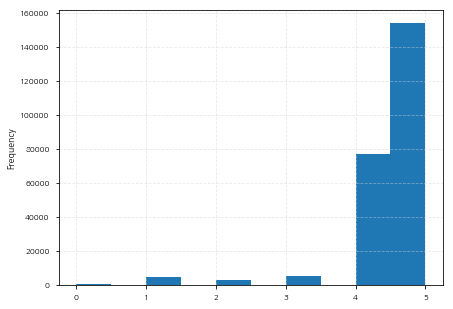

In [178]:
rec_shop_star['star_pnt'].plot(kind='hist')

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [179]:
print(rec_shop_star.mem_no.is_unique)
print(rec_shop_star.shop_no.is_unique)

False
False


In [180]:
print(len(rec_shop_star.mem_no.unique()))
print(len(rec_shop_star.shop_no.unique()))

202606
51577


In [181]:
# matrix partial
rec_shop_star[:50].pivot_table(values='star_pnt', index='mem_no', columns='shop_no', aggfunc='mean').fillna('')

shop_no,7310,202358,396817,419467,439793,491129,514268,532483,548721,565404,570728,581036,583739,584239,587532,614551,618788,625561,627441,628081,632012,634231,643662,655058,662080,667062,677885,694523,695633,699023,702241,705530,707268,715079,716622,721620,722839,727663,731653,732519,735492,735870,735909,737120,737295,738861,740278,741125,744027,746999
mem_no,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202002872,,,,,,,,,,,,,,,,,,4,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202002942,,,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202003094,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,,,
141202003266,,,,5,,,,,,,,,,,4,,,,,4,,,,,,,,,,5,,,,,,,,,,,,,,,,,4,,,
141202003376,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,
141202003429,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202003441,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,
141202003446,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,5,5
141202003460,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,


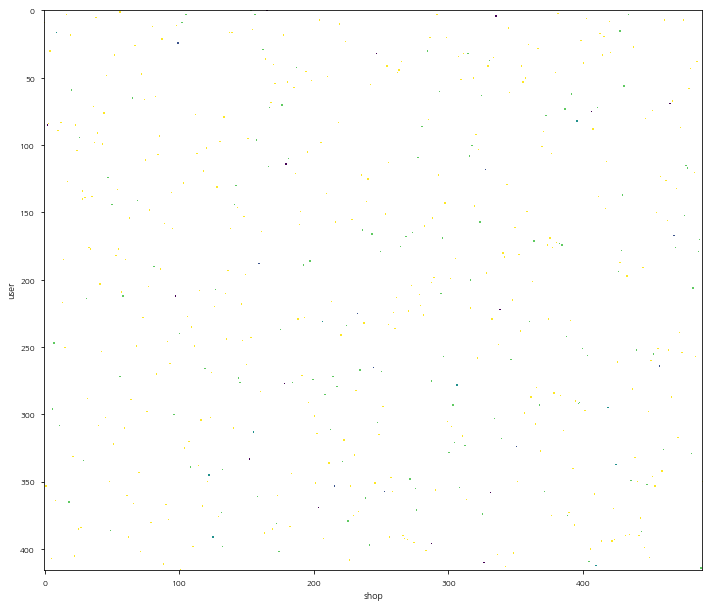

In [182]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(rec_shop_star[:500].pivot_table(values='star_pnt', index='mem_no', columns='shop_no', aggfunc='mean'))

plt.ylabel("user")
plt.xlabel("shop")
plt.tight_layout()
plt.show()

In [183]:
import surprise
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

reader = Reader()

In [184]:
data = Dataset.load_from_df(rec_shop_star, reader)

In [185]:
rec_shop_star.head()

,mem_no,shop_no,star_pnt
0,141202002872,625561,4.0
1,141202002872,634231,1.0
2,141202002942,532483,5.0
3,141202003094,727663,5.0
4,141202003266,699023,5.0


In [186]:
data

<surprise.dataset.DatasetAutoFolds instance at 0x1a1e076320>

### Baseline model
- https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration

1. [옵션 지졍](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration)

```python
# 옵션 지정 예시1
bsl_options = {'method': 'als','n_epochs': 5, 'reg_u': 12, 'reg_i': 5}

# 옵션 지정 예시2
bsl_options = {'method': 'sgd', 'learning_rate': .00005}
```

2. 객체생성
3. k-fold 트레이닝 및 모수추정
4. 테스트셋에 평가

In [187]:
bsl_options = {'method': 'als'}

baseline = surprise.BaselineOnly(bsl_options=bsl_options)

In [188]:
evaluate(baseline, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 0.7567
MAE:  0.5717
------------
Fold 2
Estimating biases using als...
RMSE: 0.7564
MAE:  0.5712
------------
Fold 3
Estimating biases using als...
RMSE: 0.7508
MAE:  0.5683
------------
Fold 4
Estimating biases using als...
RMSE: 0.7540
MAE:  0.5696
------------
Fold 5
Estimating biases using als...
RMSE: 0.7562
MAE:  0.5707
------------
------------
Mean RMSE: 0.7548
Mean MAE : 0.5703
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.5716790252900463,
                             0.5711960282260865,
                             0.5682983148024734,
                             0.5695849337697834,
                             0.5706826064221069],
                            'rmse': [0.756654039325512,
                             0.7564298598703665,
                             0.7507648058523536,
                             0.753995921944758,
                             0.7561525031775675]})

In [189]:
trainset = data.build_full_trainset()
baseline.train(trainset)

Estimating biases using als...


In [190]:
rec_shop_star[rec_shop_star['mem_no'] == 141202003266]

,mem_no,shop_no,star_pnt
4,141202003266,699023,5.0
5,141202003266,628081,4.0
6,141202003266,419467,5.0
7,141202003266,587532,4.0
8,141202003266,740278,4.0


In [191]:
print(baseline.predict(141202003266, 699023))
print(baseline.predict(141202003266, 740278))

print(baseline.predict(141202003266, 554100)) # never gives any pnt
print(baseline.predict(141202003266, 625561)) # never gives any pnt

user: 141202003266 item: 699023     r_ui = None   est = 4.70   {u'was_impossible': False}
user: 141202003266 item: 740278     r_ui = None   est = 4.59   {u'was_impossible': False}
user: 141202003266 item: 554100     r_ui = None   est = 4.73   {u'was_impossible': False}
user: 141202003266 item: 625561     r_ui = None   est = 4.50   {u'was_impossible': False}


In [192]:
shop_list = rec_shop_star['shop_no'].unique().tolist()

def get_prediction_by_baseline(mem_no):

    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = baseline.predict(mem_no, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(int)

        # remove if shop_no exists
        remove = rec_shop_star[rec_shop_star['mem_no'] == mem_no][['shop_no', 'star_pnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("star_pnt == 'unknown'").drop("star_pnt", axis=1)

In [193]:
print(shop_list[:100])

[625561, 634231, 532483, 727663, 699023, 628081, 419467, 587532, 740278, 715079, 491129, 732519, 746999, 655058, 744027, 737120, 7310, 584239, 662080, 581036, 565404, 716622, 627441, 738861, 618788, 614551, 396817, 735492, 643662, 439793, 735909, 695633, 702241, 570728, 731653, 667062, 583739, 721620, 548721, 741125, 722839, 632012, 202358, 694523, 737295, 705530, 677885, 707268, 514268, 735870, 704670, 714618, 633210, 712894, 683772, 749738, 732263, 639077, 680948, 712463, 720243, 646895, 748235, 683000, 650660, 682408, 726689, 554100, 508460, 656822, 708322, 721241, 704906, 652518, 721138, 644115, 639247, 675944, 740122, 646336, 747736, 441617, 699884, 716740, 729845, 710796, 566506, 547510, 560669, 745122, 637651, 744824, 643340, 485620, 734940, 635732, 728559, 742724, 733799, 502405]


In [194]:
get_prediction_by_baseline(141202003266)[:10]

,shop_no,est_value
67,554100,4.725863
16,7310,4.662376
39,741125,4.656024
75,644115,4.644684
74,721138,4.640047
40,722839,4.632227
64,650660,4.631109
42,202358,4.629769
62,748235,4.629530
11,732519,4.623363


In [195]:
# the user's rating histroy
rec_shop_star[rec_shop_star['mem_no'] == 141202003266]

,mem_no,shop_no,star_pnt
4,141202003266,699023,5.0
5,141202003266,628081,4.0
6,141202003266,419467,5.0
7,141202003266,587532,4.0
8,141202003266,740278,4.0


In [196]:
get_prediction_by_baseline(141202002872)[:10]

,shop_no,est_value
67,554100,4.565590
4,699023,4.542423
16,7310,4.502102
39,741125,4.495751
75,644115,4.484411
74,721138,4.479773
40,722839,4.471953
64,650660,4.470836
7,587532,4.470827
42,202358,4.469495


### Neighborhood Model
- similarity index: https://surprise.readthedocs.io/en/stable/similarities.html
- model type: https://surprise.readthedocs.io/en/stable/knn_inspired.html
- **Top x item & baseline과 결합해서 사용**

```python
## option 예시
sim_options = {'name': 'MSD', 'user_based': True, 'min_support':100, 'shrinkage':100}

## name: {"MSD", "cosine", "pearson", "pearson_baseline"}

```


In [197]:
sim_options = {'name': 'msd', 'user_based': True, 'k': 5}

knn_user_based = surprise.KNNBasic(sim_options=sim_options)

In [198]:
rec_shop_star.head()

,mem_no,shop_no,star_pnt
0,141202002872,625561,4.0
1,141202002872,634231,1.0
2,141202002942,532483,5.0
3,141202003094,727663,5.0
4,141202003266,699023,5.0


In [199]:
star_cnt_by_shop = rec_shop_star.groupby("shop_no")['star_pnt'].size()
cut = np.percentile(star_cnt_by_shop, 99.5)

print(cut)

55.0


In [200]:
myshop = star_cnt_by_shop[star_cnt_by_shop >= cut].to_frame().reset_index().drop('star_pnt', axis=1)
myshop['flag'] = 'top'

myshop[:5]

,shop_no,flag
0,27746,top
1,28963,top
2,52337,top
3,77165,top
4,84359,top


In [201]:
rec_shop_star_top = rec_shop_star.merge(myshop, on='shop_no', how='left')\
                                   .query("flag == 'top'").drop("flag", axis=1)

In [202]:
rec_shop_star_top.head()

,mem_no,shop_no,star_pnt
10,141202003429,491129,5.0
22,141202004000,627441,5.0
31,141202004583,695633,5.0
40,141202005521,722839,5.0
42,141203000450,202358,5.0


In [203]:
rec_shop_star_top.shape

(19777, 3)

In [204]:
data = Dataset.load_from_df(rec_shop_star_top, reader)

In [205]:
evaluate(knn_user_based, data, measures=['MAE', 'RMSE'])

Evaluating MAE, RMSE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.4949
RMSE: 0.6068
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.4910
RMSE: 0.5810
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.5063
RMSE: 0.6230
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.5029
RMSE: 0.6060
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.4976
RMSE: 0.6047
------------
------------
Mean MAE : 0.4986
Mean RMSE: 0.6043
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.49488818200714063,
                             0.49101212543325434,
                             0.5063312697912943,
                             0.5029076449564465,
                             0.4976421295372047],
                            'rmse': [0.6067973928308131,
                             0.5810003882466616,
                             0.6229824351978122,
                             0.6059766588850142,
                             0.6047132987203007]})

In [206]:
trainset = data.build_full_trainset()
knn_user_based.train(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [207]:
rec_shop_star_top[:10]

,mem_no,shop_no,star_pnt
10,141202003429,491129,5.0
22,141202004000,627441,5.0
31,141202004583,695633,5.0
40,141202005521,722839,5.0
42,141203000450,202358,5.0
52,141203000781,633210,5.0
62,141203001637,748235,5.0
65,141203001866,682408,5.0
67,141203002019,554100,5.0
97,141203004706,742724,5.0


In [208]:
shop_list = rec_shop_star_top['shop_no'].unique().tolist()

def get_prediction_by_knn(mem_no):

    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = knn_user_based.predict(mem_no, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(int)

        # remove if shop_no exists
        remove = rec_shop_star[rec_shop_star['mem_no'] == mem_no][['shop_no', 'star_pnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("star_pnt == 'unknown'").drop("star_pnt", axis=1)

In [209]:
get_prediction_by_knn(141202004000)[:10]

,shop_no,est_value
74,648995,5.000000
63,660912,4.627244
73,718696,4.627244
72,679226,4.627244
71,628719,4.627244
70,639254,4.627244
69,84359,4.627244
68,476104,4.627244
67,688137,4.627244
66,718570,4.627244


### Latent Factor Model: SVD
- http://surprise.readthedocs.io/en/latest/matrix_factorization.html

In [210]:
svd = surprise.SVD()

In [211]:
data = Dataset.load_from_df(rec_shop_star, reader)

In [212]:
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.7534
MAE:  0.5648
------------
Fold 2
RMSE: 0.7473
MAE:  0.5626
------------
Fold 3
RMSE: 0.7656
MAE:  0.5709
------------
Fold 4
RMSE: 0.7570
MAE:  0.5667
------------
Fold 5
RMSE: 0.7580
MAE:  0.5681
------------
------------
Mean RMSE: 0.7563
Mean MAE : 0.5666
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.564780460971211,
                             0.5626280774561067,
                             0.5708760178976044,
                             0.566651187264615,
                             0.5681434444304048],
                            'rmse': [0.7534399613044137,
                             0.7472659735114145,
                             0.7656150997000436,
                             0.7569682236134416,
                             0.75803976013417]})

In [213]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [214]:
shop_list = rec_shop_star['shop_no'].unique().tolist()

def get_prediction_svd(mem_no):
    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = svd.predict(mem_no, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(int)        

        # remove if shop_no exists
        remove = rec_shop_star[rec_shop_star['mem_no'] == mem_no][['shop_no', 'star_pnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("star_pnt == 'unknown'").drop("star_pnt", axis=1)

In [215]:
get_prediction_svd(141202003266)[:10]

,shop_no,est_value
31,695633,4.791675
67,554100,4.788561
68,508460,4.768072
62,748235,4.756688
96,728559,4.718867
65,682408,4.711726
39,741125,4.693633
35,667062,4.690571
10,491129,4.682627
74,721138,4.681453


### 추가 고려사항
 - 반복적인 실험설계 및 지표 트래킹으로 적합한 hybrid 모델을 찾아가는 과정 필요
 - 유저 특성을 나타내는 변수를 기반으로 정확성 상승 필요
     - 주요 카테고리, 방문횟수, 재주문율, 지역, 연령 등
 - Business Rules   

### 7.3 AB Testing 및 사전/사후 설문

**1. A/B 테스트 정의**
    - 임의적인 방식으로 사용자를 분류하고 각각 다른 자극/정보를 제공한 후, 사용자의 반응을 테스트하여 서비스를 개선 
    - 기획자가 시나리오 1안과 2안을 가지고 있는데 두 개중 어떤 안이 더 효과적일지 모르겠다고 해보자.
    - 그렇다면 사용자를 임의로 두 그룹으로 나누고 한 그룹에는 1안을, 다른 한 그룹에는 2안을 보여주고 사용성을 파악하여 최종안을 결정할 수 있다. 
![img](abtest_def.png)

**2. 사용자를 임의적인(Randomized) 방식으로 분류하는 것이 포인트**
    - 원인과 결과의 관계, 즉 인과관계를 명확히 규명해야 하는 실험 설계에서 가장 중요한 것은 외부요인을 완벽히 제거하는 것이다.
    - 예를 들어, 마케팅팀에서 프로모션 A방식과 B방식의 결제율 차이를 파악하려고 한다고 해보자. 그런데 한 그룹에는 20대 사용자를, 다른 그룹에는 50대 사용자를 배정한다면?
    - 이런 경우 그룹 간 결제율의 차이가 프로모션 방식으로 인한 결과라고 주장하기 어렵게 된다. (연령에 의한 차이라고 봐도 무방하기 때문이다)
    - 따라서 임의적으로 사용자를 그룹에 배정해, 연령과 같은 불필요한 외부요인을 사전에 모두 통제해야 한다.

**3. 충분한 샘플 수(Observations) 확보와 일반화(Generalization) 가능성을 반드시 고려해야**
    - 전체 사용자가 아닌 일부의 사용자를 대상으로 테스트를 진행하는 경우가 많다.
    - 그렇다면, 모든 사용자(새로운 유입될 사용자 포함)를 대상으로 일관적인 결과가 나타날 것인지 어떻게 확신할 수 있을까?
    - 한 실험의 결과가 우연으로 발생한 것이 아닌, 쉽게 바뀌지 않을(Robust) 결과라는 것을 확인하기 위해 가능한 많은 샘플 수를 확보하고 T-test, ANOVA 등 통계적 분석방법을 실행해야 한다.

**4. A/B 테스트 시행 방법**
    - A/B 테스트 발의
        - 테스트 목적 및 배경을 논의
        - 예상 일정에 대해 협의
    - 로그 정의/설계
        - 로그 화면 및 이벤트, 액션 등에 대해 정의
    - 모듈 적용 및 개발
        - 서비스에 모듈을 적용하고 필요시 개발을 진행
    - A/B 테스트 진행
        - 테스트를 진행하고 상황을 모니터링
    - 데이터를 수집 및 처리
    - 분석 및 주요 결과 공유
    - 필요시 위 사이클 반복

**5. 기대 효과 및 한계점**
    - 과학적인 의사결정 방식: 직감에 의존한 의사결정은 매번 성공적인 결과를 보장해주지 않는다. 소비자의 행동과 그로 인한 결과(데이터)에 근거해 의사결정을 할 경우 서비스의 성공 가능성을 높일 수 있다.또한 잘못된 의사결정으로 인한 금전적/시간적 손해를 줄일 수 있고, 소비자의 서비즈 만족도를 높이기 위한 기반을 마련해줄 수 있다.
    - 결과에 대한 원인을 깊이 있게 알기 어려움. A/B 테스트는 설계된 범위 안에서 특정하게 원하는 결과만을 도출할 수 있다. 예를 들어, A가 B 보다 낫다는 식의 단순한 결과만을 말해준다. 왜 A가 더 나은지 그 이유는 직접 물어보지 않는 한 명확히 알 수 없다. (사실 직접 물어볼 수 있다해도 진실을 말해줄 것이라는 보장은 없다)
    - 성공적인 A/B 테스트를 보장하는 요소: 거창한 목적과 완벽한 준비에 에너지를 쏟는 것이 아니라, 작고 빠르게 여러번 반복하면서 프로세스 및 서비스를 개선하는 것이 효과적일 것이다.

### 7.4 설문을 통한 유저 피드백
- 설문 대상자 선택 (내부, 외부)
- 스크리닝 문항 구축
- 설문 문항 구축
- 데이터 수집 및 분석
- 보고서 작성 및 피드백 반영

![img](rank_framework.png)    
